Nous allons dans un premier temps **traiter le jeu de données afin de repérer des variables pertinentes** pour les traitements à venir et **automatiser ces traitements** pour éviter de répéter ces opérations.

## <font color="#00afe6">Sommaire</font>
[1.1. Colonnes et lignes vides / Doublons](#section_1)     
[1.2. Variables redondantes](#section_2)     
[1.3. Les pays de l'analyse](#section_3)     
[1.4. Les catégories de produits](#section_4)          
[1.5. Compléter les valeurs manquantes ou aberrantes](#section_5)     
[1.6. Calcul des Nutri-Scores manquants](#section_6)     

## <font color="#00afe6">1. Nettoyage des données</font>

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

Le jeu de données téléchargé en CSV sur le site [Open Food Facts](https://world.openfoodfacts.org/) est importé dans le Notebook via la méthode `read_csv` de la librairie `pandas`

In [3]:
def read_config(file_path='./config.yaml'):
    """Reads configuration file
    Args:
        file_path (str, optional): file path
    Returns:
        dict: Parsed configuration file
    """
    with open(file_path, "r") as f:
        return yaml.safe_load(f)

def get_data(file_path=None, nrows=None):
    """Loads data
    Args:
        file_path (str, optional): file path of dataset
            By default load data set from static web page
        nrows (int, optional): number or rows to loads from dataset
            By default loads all dataset  
    Returns:
        dataframe: output dataframe
    """
    if file_path is None:
        cfg = read_config()
        file_path = cfg['paths']['eng_dataset']
    print("Reading dataset ...")    
    return pd.read_csv(file_path,sep="\t", encoding="utf-8",
                       nrows=nrows, low_memory=False)

Reading dataset ...
data set shape is (2830755, 165)


In [ ]:
datas = get_data(file_path = "df_withoutduplicatefeatures4.csv")
print(f"data set shape is {datas.shape}")

Affichons à présent quelques lignes au hasard du dataset puis regardons sa `shape`

In [4]:
datas.sample(5)

code                                                url   
423368   0202710030968  http://world-en.openfoodfacts.org/product/0202...  \
1204555  3277167010952  http://world-en.openfoodfacts.org/product/3277...   
1303745  3455140005199  http://world-en.openfoodfacts.org/product/3455...   
372601   0085239286456  http://world-en.openfoodfacts.org/product/0085...   
442468   0210735031624  http://world-en.openfoodfacts.org/product/0210...   

                                product_name abbreviated_product_name   
423368                          chèvre/brebs                      NaN  \
1204555           Rillettes pures de canards                      NaN   
1303745                  Confiture de cassis                      NaN   
372601   Dino Track Whole Wheat Cheese Pizza                      NaN   
442468                    Pavés à l'échalote                      NaN   

        generic_name quantity packaging_en packaging_text   
423368           NaN      NaN          NaN            NaN  \
1204555          NaN      NaN          NaN            NaN   
1303745          NaN    430 g          NaN            NaN   
372601           NaN     6 oz          NaN            NaN   
442468           NaN      NaN          NaN            NaN   

                                  brands   
423368                         Itchebais  \
1204555                              NaN   
1303745  La Francomtoise de Confiturerie   
372601                               NaN   
442468                               NaN   

                                             categories_en  ...   
423368                                                 NaN  ...  \
1204555  Meats and their products,Spreads,Meats,Prepare...  ...   
1303745  Plant-based foods and beverages,Plant-based fo...  ...   
372601                                                 NaN  ...   
442468                                                 NaN  ...   

        carbon-footprint-from-meat-or-fish_100g nutrition-score-fr_100g   
423368                                      NaN                     NaN  \
1204555                                     NaN                    19.0   
1303745                                     NaN                     7.0   
372601                                      NaN                     NaN   
442468                                      NaN                     NaN   

        nutrition-score-uk_100g glycemic-index_100g water-hardness_100g   
423368                      NaN                 NaN                 NaN  \
1204555                     NaN                 NaN                 NaN   
1303745                     NaN                 NaN                 NaN   
372601                      NaN                 NaN                 NaN   
442468                      NaN                 NaN                 NaN   

        choline_100g phylloquinone_100g beta-glucan_100g inositol_100g   
423368           NaN                NaN              NaN           NaN  \
1204555          NaN                NaN              NaN           NaN   
1303745          NaN                NaN              NaN           NaN   
372601           NaN                NaN              NaN           NaN   
442468           NaN                NaN              NaN           NaN   

        carnitine_100g  
423368             NaN  
1204555            NaN  
1303745            NaN  
372601             NaN  
442468             NaN  

[5 rows x 165 columns]

In [5]:
print ("Le dataset compte {} lignes et {} variables".format(datas.shape[0], datas.shape[1]))

Le dataset compte 2830755 lignes et 165 variables


### <font color="#ea1c60" id="section_1">1.1. Colonnes et lignes vides / Doublons</font>
Regardons à présent les **variables qui comptent le plus de valeurs null**:

In [6]:
def null_factor(df, tx_threshold=50):
  null_rate = ((datas.isnull().sum() / datas.shape[0])*100).sort_values(ascending=False).reset_index()
  null_rate.columns = ['Variable','Taux_de_Null']
  high_null_rate = null_rate[null_rate.Taux_de_Null >= tx_threshold]
  return high_null_rate

In [7]:
full_null_rate = null_factor(datas, 100)
full_null_rate

Empty DataFrame
Columns: [Variable, Taux_de_Null]
Index: []

Nous allons regarder le taux de remplissage des variables graphiquement et fixer un **seuil de suppression à 25% de taux de remplissage** :

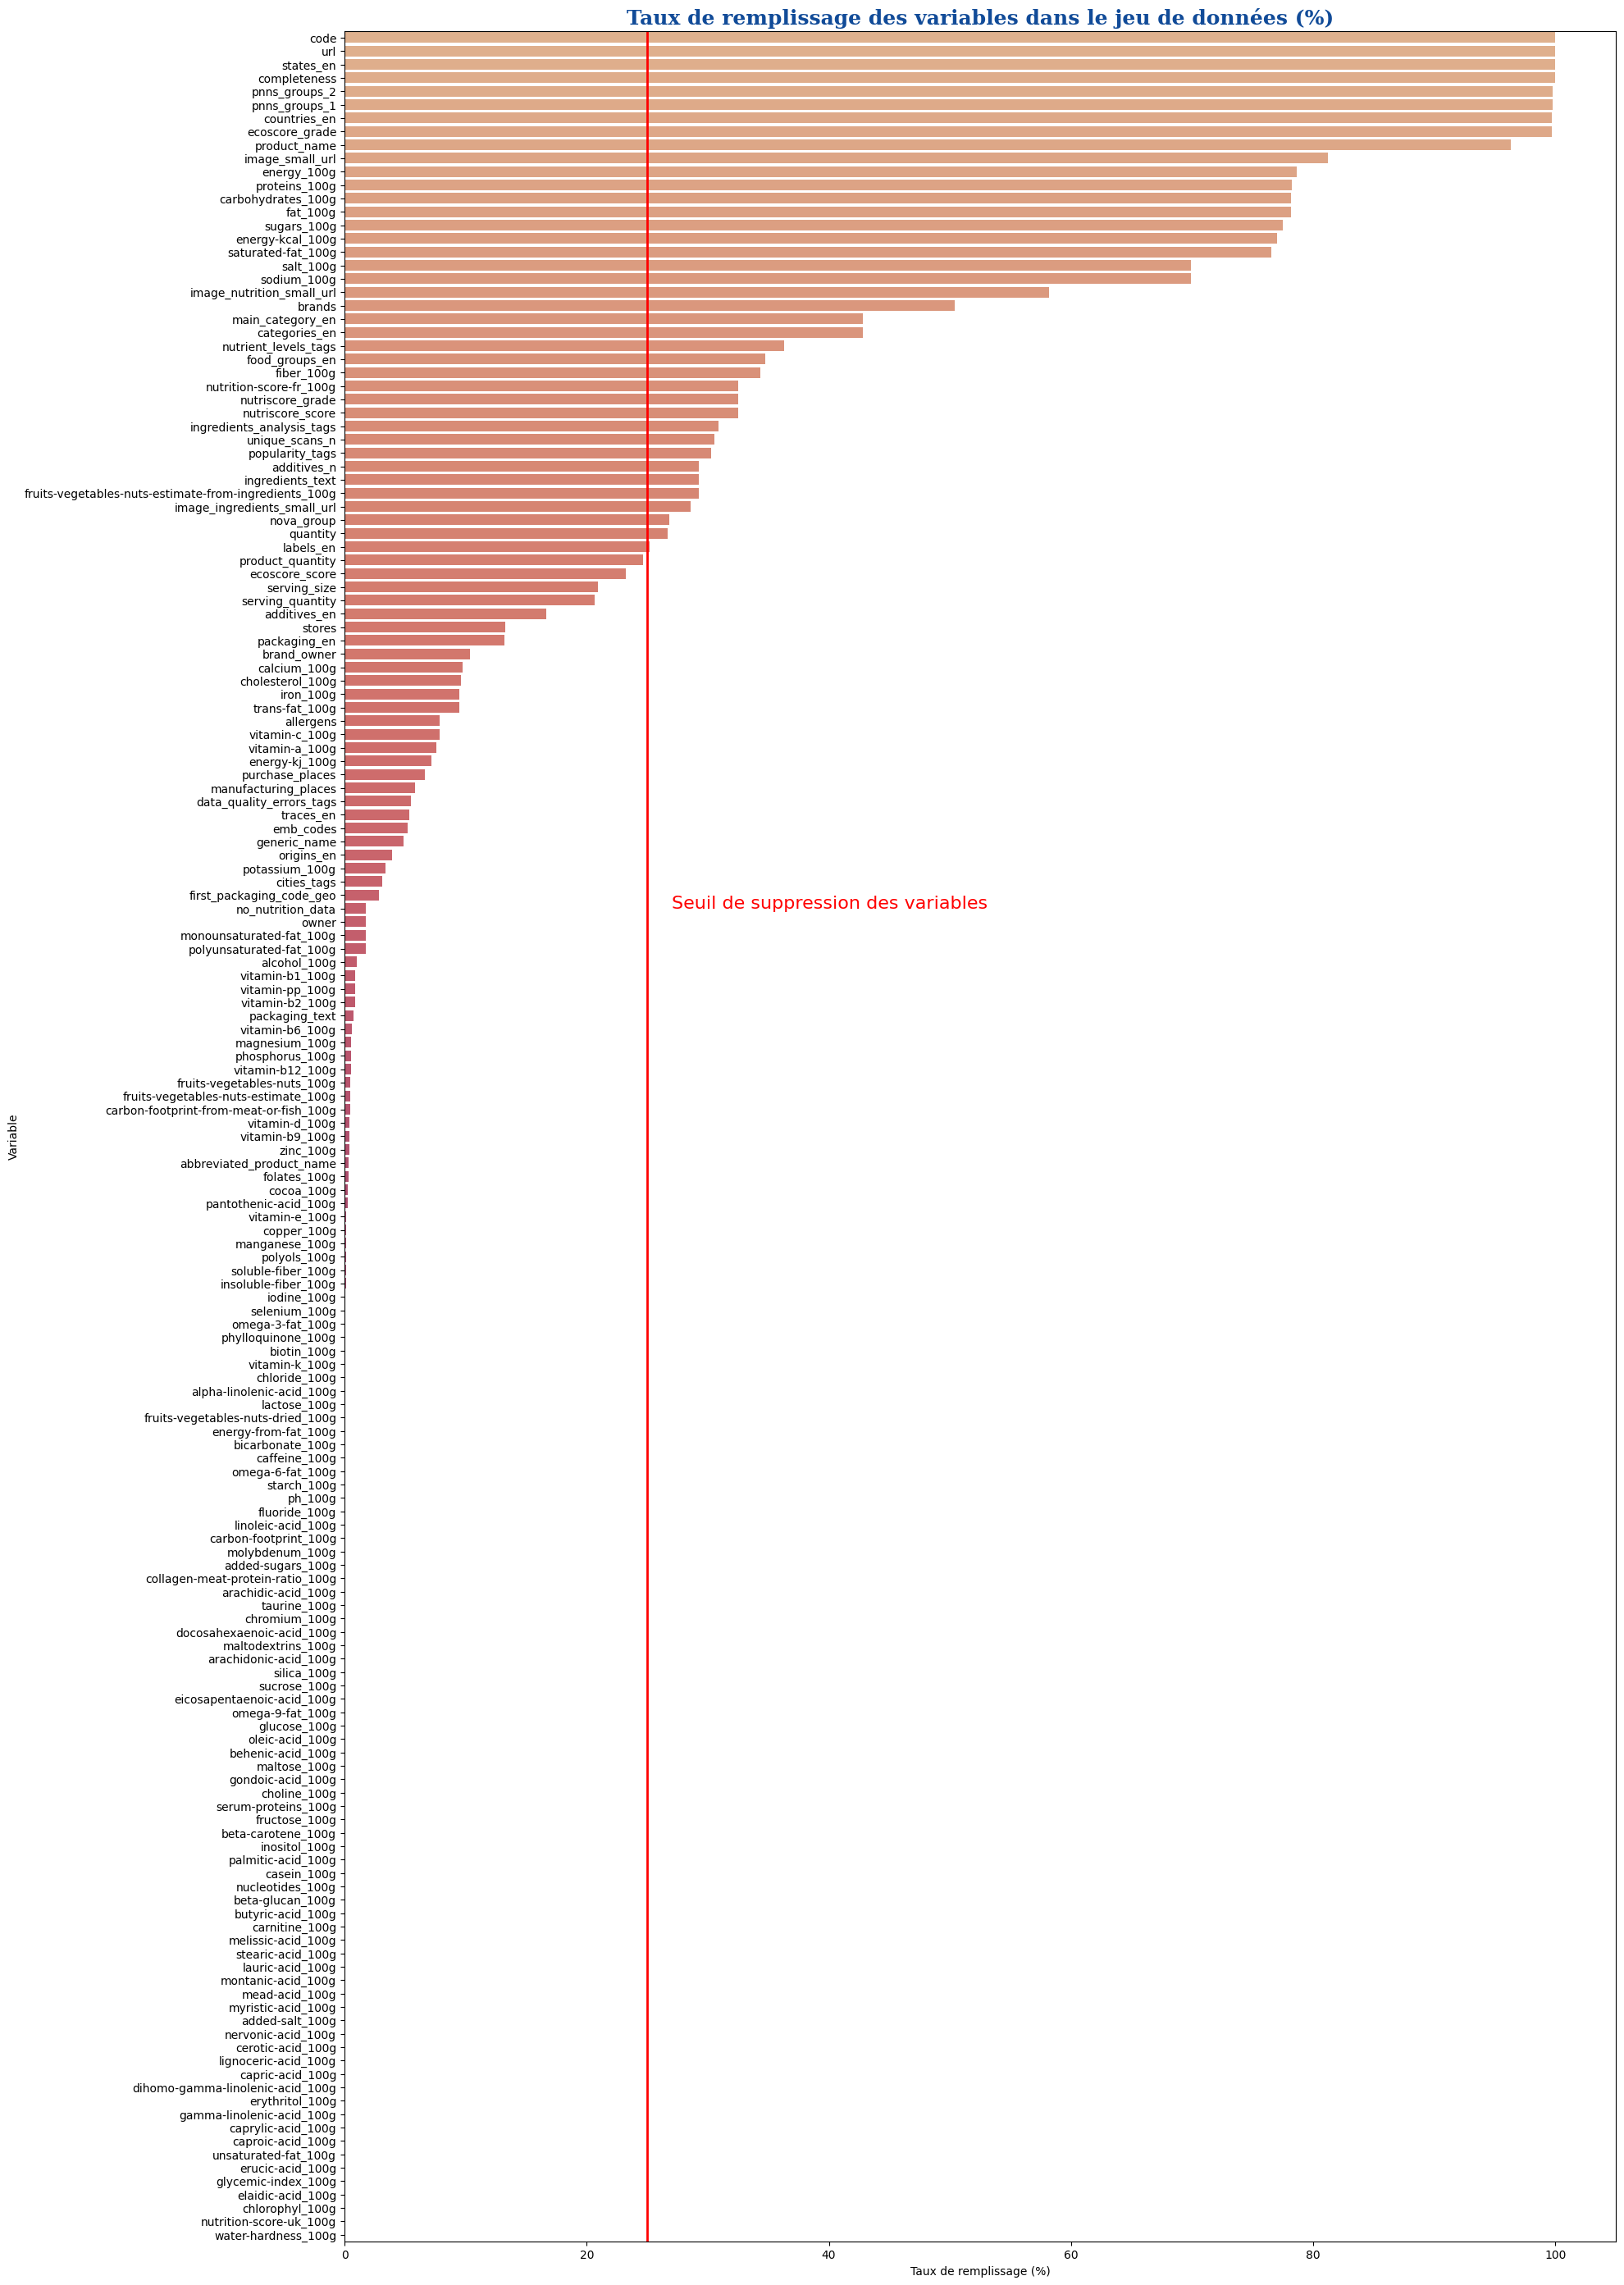

In [8]:
filling_features = null_factor(datas, 0)
filling_features["Taux_de_Null"] = 100-filling_features["Taux_de_Null"]
filling_features = filling_features.sort_values("Taux_de_Null", ascending=False) 

#Seuil de suppression
sup_threshold = 25

fig = plt.figure(figsize=(20, 35))

font_title = {'family': 'serif',
              'color':  '#114b98',
              'weight': 'bold',
              'size': 18,
             }

sns.barplot(x="Taux_de_Null", y="Variable", data=filling_features, palette="flare")
#Seuil pour suppression des varaibles
plt.axvline(x=sup_threshold, linewidth=2, color = 'r')
plt.text(sup_threshold+2, 65, 'Seuil de suppression des variables', fontsize = 16, color = 'r')

plt.title("Taux de remplissage des variables dans le jeu de données (%)", fontdict=font_title)
plt.xlabel("Taux de remplissage (%)")
plt.show()

In [9]:
#Liste des variables à conserver
features_to_conserve = list(filling_features.loc[filling_features['Taux_de_Null']>=sup_threshold, 'Variable'].values)
#Liste des variables supprimées
deleted_features = list(filling_features.loc[filling_features['Taux_de_Null']<sup_threshold, 'Variable'].values)

155 features sur 184 ont un taux de valeurs nulles supérieur à 50%, ce qui représente une très grosse part de données manquantes. **La majeure partie de ces variables ne peuvent pas être recalculées** puisqu'il s'agit de mesures physico-chimiques directes sur les produits.

Il reste à présent 50 features dans notre dataset. Pour la suite des analyses, nous aurons besoin d'un minimum d'informations sur **les nutriments** des produits. Ces données sont **suffixées avec** `_100g`. Nous allons donc **conserver les lignes pour lesquelles au moins une de ces features est complétée** :

In [10]:
def search_componant(df, suffix='_100g'):
  componant = []
  for col in df.columns:
      if '_100g' in col: componant.append(col)
  df_subset_columns = df[componant]
  return df_subset_columns

In [11]:
df_subset_nutients = search_componant(datas,'_100g')
df_subset_nutients.head()

energy-kj_100g  energy-kcal_100g  energy_100g  energy-from-fat_100g   
0             NaN               NaN          NaN                   NaN  \
1             NaN             165.0        690.0                   NaN   
2             NaN               NaN          NaN                   NaN   
3             NaN              57.0        238.0                   NaN   
4             NaN             375.0       1569.0                   NaN   

   fat_100g  saturated-fat_100g  butyric-acid_100g  caproic-acid_100g   
0       NaN                 NaN                NaN                NaN  \
1       2.0                2.00                NaN                NaN   
2       1.4                0.90                NaN                NaN   
3       0.2                0.10                NaN                NaN   
4       7.0                3.08                NaN                NaN   

   caprylic-acid_100g  capric-acid_100g  ...   
0                 NaN               NaN  ...  \
1                 NaN               NaN  ...   
2                 NaN               NaN  ...   
3                 NaN               NaN  ...   
4                 NaN               NaN  ...   

   carbon-footprint-from-meat-or-fish_100g  nutrition-score-fr_100g   
0                                      NaN                      NaN  \
1                                      NaN                      NaN   
2                                      NaN                      NaN   
3                                      NaN                     -5.0   
4                                      NaN                      NaN   

   nutrition-score-uk_100g  glycemic-index_100g  water-hardness_100g   
0                      NaN                  NaN                  NaN  \
1                      NaN                  NaN                  NaN   
2                      NaN                  NaN                  NaN   
3                      NaN                  NaN                  NaN   
4                      NaN                  NaN                  NaN   

   choline_100g  phylloquinone_100g  beta-glucan_100g  inositol_100g   
0           NaN                 NaN               NaN            NaN  \
1           NaN                 NaN               NaN            NaN   
2           NaN                 NaN               NaN            NaN   
3           NaN                 NaN               NaN            NaN   
4           NaN                 NaN               NaN            NaN   

   carnitine_100g  
0             NaN  
1             NaN  
2             NaN  
3             NaN  
4             NaN  

[5 rows x 116 columns]

In [12]:
print('Lignes nutriments (_100g) vides: {}'.format(df_subset_nutients.isnull().all(axis=1).sum()))

Lignes nutriments (_100g) vides: 474355


In [13]:
datas = datas[df_subset_nutients.notnull().any(axis=1)]
datas.shape

(2356400, 165)

Notre jeu de données est à présent débarassé des lignes et colonnes peu complétées. Nous allons à présent **rechercher et supprimer les doublons**.

In [14]:
# Suppression des doublons en fonction du code
datas.drop_duplicates(subset ="code", keep = 'last', inplace=True)

In [15]:
datas[(datas["product_name"].isnull()==False) 
      & (datas["brands"].isnull()==False)].groupby(by=["product_name","brands"])["code"].nunique().sort_values(ascending=False)

product_name                 brands                 
Burger vegetariana           Bonarea                    305
Filet de poulet              La Nouvelle Agriculture    218
Burger vegana                Bonarea                    205
Finísimo de pechuga de pavo  Bonarea                    155
Filet de poulet              Le Gaulois                 146
                                                       ... 
Galette frangipane           Cora                         1
                             Leader Price                 1
                             Match                        1
                             Monoprix                     1
🤬                            🤬                            1
Name: code, Length: 1133879, dtype: int64

In [16]:
datas = datas[(datas["product_name"]!="🤬") 
              & (datas["brands"]!="🤬")]

In [17]:
# Suppression des doublons sur marque et produit en conservant les valeurs nulles
datas = datas[(~datas.duplicated(["product_name","brands"],keep="last")) 
      | ((datas['product_name'].isnull()) & (datas['brands'].isnull()))]

In [18]:
datas.shape

(1877499, 165)

### <font color="#ea1c60" id="section_2">1.2. Variables redondantes</font>

Certaines variables dans le dataset sont en réalité des variables redondantes. C'est par exemple le cas des variables suffixées par `_tags` ou `_en` qui ne font que reprendre d'autres features traduites ou simplifiées.

Nous les avons donc supprimé au prealable

On remarque dans ces quelques exemples que les variables sont bien redondantes. Nous allons donc, lorsque la colonne suffixée `_en` existe, supprimer toutes les autres colonnes identiques non suffixées ou contenant `_tags` :

**Les dates également comportent une certaine redondance**. Entre les timestamp et les dates au format "yyyy-mm-dd", il est nécessaire d'en éliminer :

In [21]:
#datas['created_datetime'] = pd.to_datetime(datas['created_t'], unit='s')
#datas['last_modified_datetime'] = pd.to_datetime(datas['last_modified_t'], unit='s')
#datas = datas.drop(['created_t','last_modified_t'], axis=1)
#datas.head()

Nous pouvons à présent regarder la **distribution des contributions par année** :

In [22]:
add_per_year = datas[['created_datetime', 'code']].groupby(by=datas['created_datetime'].dt.year).nunique()

fig=plt.figure(figsize=(12,8))

sns.set_style("whitegrid")
sns.barplot(data=add_per_year, x=add_per_year.index, y='code', color='#00afe6')

plt.title("Evolution des créations de produits dans la base par année", fontdict=font_title)
plt.xlabel("Année de création")
plt.ylabel("Nombre de créations")
plt.show()

KeyError: "['created_datetime'] not in index"

Les années de 2012 à 2016 sont visiblement bien moins représentées que les années 2017 à 2019. La mise en place du Nutri-Score a été votée dans le cadre de la **loi Santé de 2016**.

In [23]:
datas.shape

(1877499, 165)

A présent, notre dataset compte 40 variables qui ne contienent plus de redondance et 1 124 710 lignes. Nous allons maintenant nous intéresser à une variable importante : le pays.

### <font color="#ea1c60" id="section_3">1.3. Les pays de l'analyse</font>

Regardons tout d'abord le nombre de pays représentés *(s'il est trop élevé, c'est que des erreurs existent)*

In [24]:
countries = datas.groupby(by="countries_en").nunique()

In [25]:
countries[['code']].head()

code
countries_en                           
123456789                             1
Afghanistan                          15
Afghanistan,Belgium,France            2
Afghanistan,Finland,France,Sweden     1
Afghanistan,France                  115

Plusieurs pays sont regroupés dans la même variable, nous allons devoir effectuer un split du texte pour visualiser tout nos pays :

In [26]:
def split_words(df, column = 'countries_en'):
  list_words = set()
  for word in df[column].str.split(','):
    if isinstance(word, float):
      continue
    list_words = set().union(word, list_words)
  return list(list_words)

In [27]:
#Liste contenant tous les pays du jeu de données (bons ou mauvais)
list_countries = split_words(datas, 'countries_en')

In [28]:
print("Nombre de pays représentés : {}".format(len(list_countries)))

Nombre de pays représentés : 882


Nous avons traiter les pays pour garder anglais.

### <font color="#ea1c60" id="section_4">1.4. Les catégories de produits</font>

Intéressons nous à présent à la catégorisation des produits. 4 variables représentent cette catégorisation de manière plus ou moins précise : `categories_en`, `main_category_en`, `pnns_groups_1`, `pnns_groups_2`.

In [29]:
datas[['categories_en','pnns_groups_1','pnns_groups_2','main_category_en',]].sample(10)

categories_en   
944437   Dairies,Fermented foods,Fermented milk product...  \
1795673                                                NaN   
1718351                                                NaN   
2339287                                                NaN   
1458210  Meats and their products,Meats,Prepared meats,...   
1437801                                                NaN   
2679243                                                NaN   
1384329  Plant-based foods and beverages,Plant-based fo...   
1667939                                                NaN   
1642068                                                NaN   

                   pnns_groups_1   pnns_groups_2  main_category_en  
944437   Milk and dairy products          Cheese           Cheeses  
1795673                  unknown         unknown               NaN  
1718351                  unknown         unknown               NaN  
2339287                  unknown         unknown               NaN  
1458210           Fish Meat Eggs  Processed meat  Poultry sausages  
1437801                  unknown         unknown               NaN  
2679243                  unknown         unknown               NaN  
1384329     Cereals and potatoes         Legumes       White beans  
1667939                  unknown         unknown               NaN  
1642068                  unknown         unknown               NaN

Nous allons regarder le **nombre total de catégories représentées** :

In [30]:
categories = split_words(df = datas, column = 'categories_en')
print("{} catégories sont représentées dans le jeu de données.".format(len(categories)))

42622 catégories sont représentées dans le jeu de données.


Ici également, nous allons regarder les **catégories les plus représentées**, après avoir remplacé les valeurs nulles et complété les valeurs inconnues des pnns avec la catégorie principale :

In [31]:
datas['categories_en'] = np.where((datas['categories_en'].isnull()==True), "unknown", 
                                 np.where(datas['categories_en'] == "", "unknown", datas['categories_en']))
datas['main_category_en'] = np.where((datas['main_category_en'].isnull()==True), "unknown", 
                                 np.where(datas['main_category_en'] == "", "unknown", datas['main_category_en']))
datas['pnns_groups_1'] = np.where((datas['pnns_groups_1'].isnull()==True), "unknown", 
                                 np.where(datas['pnns_groups_1'] == "", "unknown", datas['pnns_groups_1']))
datas['pnns_groups_2'] = np.where((datas['pnns_groups_2'].isnull()==True), "unknown", 
                                 np.where(datas['pnns_groups_2'] == "", "unknown", datas['pnns_groups_2']))

In [32]:
def top_words(df, column="countries_en", nb_top=10):
    count_keyword = dict()
    df_col = df[column].to_frame(name=column)
    for index, col in df_col.iterrows():
        if isinstance(col[column], float):
            continue
        for word in col[column].split(','):
            if word in count_keyword.keys():
                count_keyword[word] += 1
            else:
                count_keyword[word] = 1

    keyword_top = []
    for k,v in count_keyword.items():
        keyword_top.append([k,v])
    keyword_top.sort(key = lambda x:x[1], reverse = True)

    return keyword_top[:nb_top]

In [33]:
df_top_categories = pd.DataFrame(top_words(df=datas, column="categories_en", nb_top=10), 
                                 columns=["Keyword","count"])
df_top_categories

Keyword   count
0                          unknown  965781
1  Plant-based foods and beverages  286630
2                Plant-based foods  245248
3                           Snacks  187124
4                     Sweet snacks  135597
5                        Beverages  103170
6             Cereals and potatoes   92123
7                          Dairies   89366
8         Meats and their products   72121
9                  Fermented foods   69412

Il existe donc également une grande disparité dans les catégories représentées et les "unknown", les catégories inconnues l'emportent. 

Pour une meilleure visualisation, nous allons représenter le top 100 des catégories dans un nuage de mots grâce à la librairie `WordCloud` :

In [34]:
from wordcloud import WordCloud

def plot_world_cloud(df=datas,column="categories_en",nb_top=100):
  fig = plt.figure(1, figsize=(20,15))
  ax1 = fig.add_subplot(1,1,1)

  words = dict()
  trunc_occurences = top_words(df=df, column=column, nb_top=nb_top)
  for s in trunc_occurences:
    words[s[0]] = s[1]

  word_cloud = WordCloud(width=900,height=500, normalize_plurals=False,
                        background_color="white")
  word_cloud.generate_from_frequencies(words)
  ax1.imshow(word_cloud, interpolation="bilinear")
  ax1.axis('off')
  plt.title("Nuage de mots des {} meilleures {}\n".format(nb_top, column), fontsize=22)
  plt.show()


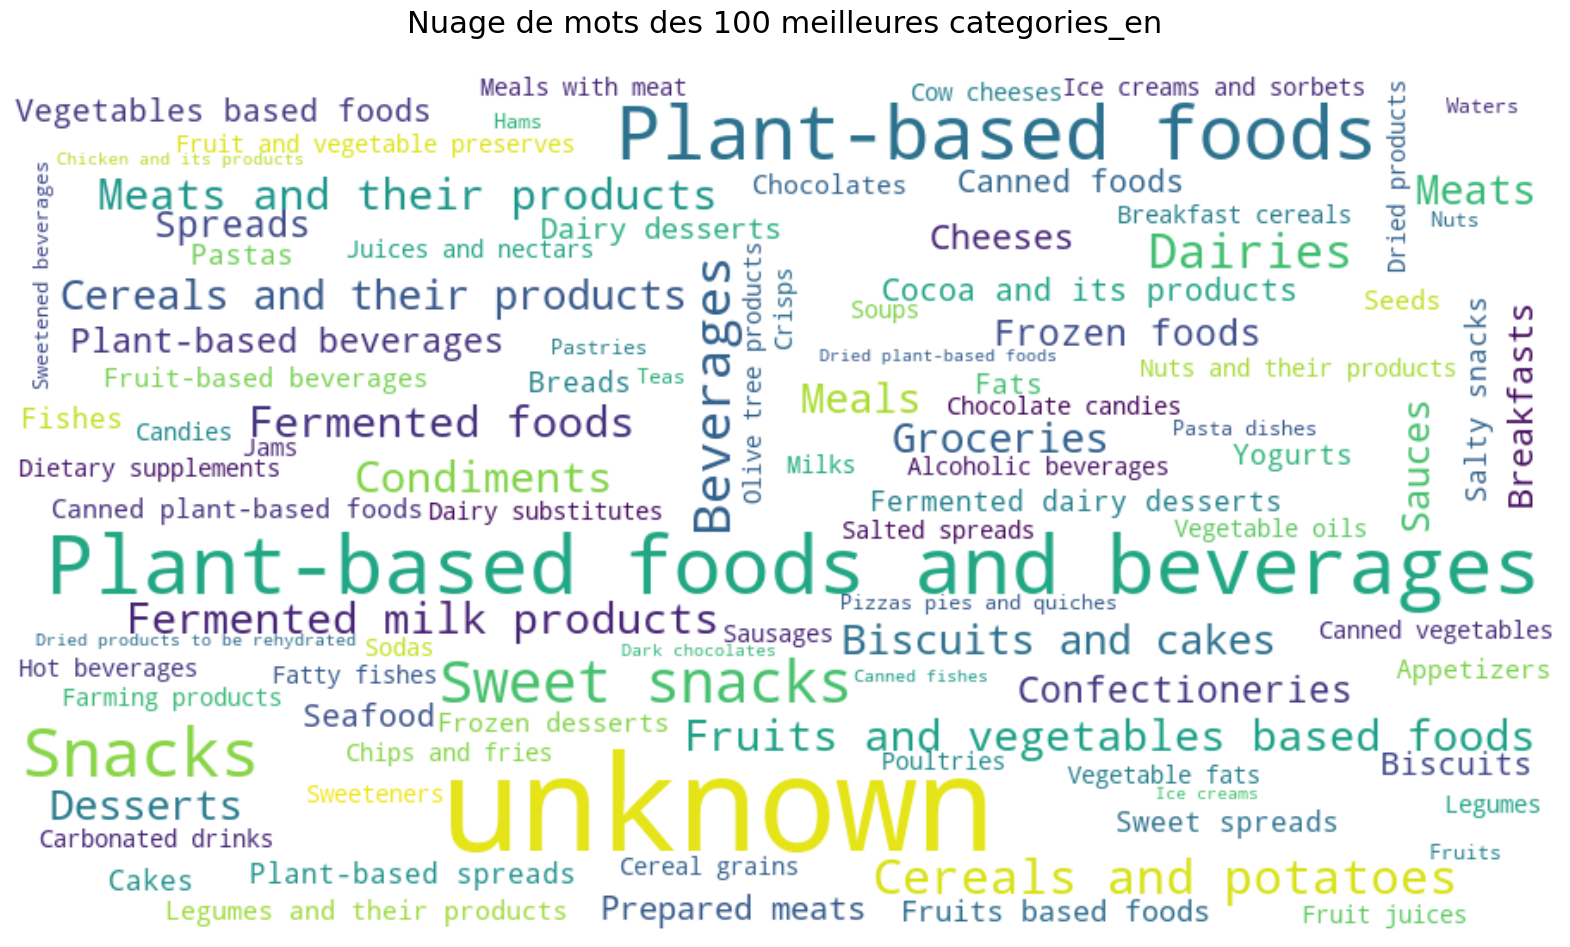

In [35]:
plot_world_cloud(df=datas,column="categories_en",nb_top=100)

Passons à présent aux variables `pnns_groups_1` et `pnns_groups_2` qui nous apporteront des informations plus précises :

In [36]:
pnns_groups_1 = split_words(df = datas, column = 'pnns_groups_1')
pnns_groups_2 = split_words(df = datas, column = 'pnns_groups_2')
print("{} catégories sont représentées dans la variable pnns_group_1.".format(len(pnns_groups_1)))
print("{} catégories sont représentées dans la variable pnns_group_2.".format(len(pnns_groups_2)))

12 catégories sont représentées dans la variable pnns_group_1.
41 catégories sont représentées dans la variable pnns_group_2.


In [37]:
pnns_groups_1

['Beverages',
 'Cereals and potatoes',
 'unknown',
 'Milk and dairy products',
 'Fish Meat Eggs',
 'Sugary snacks',
 'Alcoholic beverages',
 'Salty snacks',
 'Composite foods',
 'Fruits and vegetables',
 'sugary-snacks',
 'Fat and sauces']

On voit ici que certaines catégories sont présentes plusieurs fois mais orthographiées différement :
- 'Cereals and potatoes' et 'cereals-and-potatoes'
- 'fruits-and-vegetables' et 'Fruits and vegetables'
- ...

Nous allons donc corriger le problème en passant le texte en miniscule et en remplaçant les caractères spéciaux par un espace :

In [38]:
datas["pnns_groups_1"] = datas["pnns_groups_1"].str.lower().str.replace('-', ' ')

In [39]:
pnns_groups_1 = split_words(df = datas, column = 'pnns_groups_1')
print("{} catégories sont représentées dans la variable pnns_group_1.".format(len(pnns_groups_1)))
print(pnns_groups_1)

11 catégories sont représentées dans la variable pnns_group_1.
['salty snacks', 'milk and dairy products', 'cereals and potatoes', 'composite foods', 'unknown', 'fish meat eggs', 'fat and sauces', 'alcoholic beverages', 'beverages', 'sugary snacks', 'fruits and vegetables']


In [40]:
pnns_groups_2

['Dairy desserts',
 'Offals',
 'Milk and yogurt',
 'Fats',
 'Appetizers',
 'Fruit nectars',
 'Fruits',
 'Processed meat',
 'Ice cream',
 'Biscuits and cakes',
 'Potatoes',
 'Pastries',
 'Nuts',
 'Breakfast cereals',
 'Meat',
 'Sweetened beverages',
 'One-dish meals',
 'Teas and herbal teas and coffees',
 'Legumes',
 'Soups',
 'Bread',
 'Sweets',
 'Dried fruits',
 'Dressings and sauces',
 'Waters and flavored waters',
 'Plant-based milk substitutes',
 'Fruit juices',
 'Eggs',
 'Chocolate products',
 'Alcoholic beverages',
 'Artificially sweetened beverages',
 'Pizza pies and quiches',
 'pastries',
 'unknown',
 'Vegetables',
 'Fish and seafood',
 'Unsweetened beverages',
 'Salty and fatty products',
 'Cereals',
 'Sandwiches',
 'Cheese']

In [41]:
datas["pnns_groups_2"] = datas["pnns_groups_2"].str.lower().str.replace('-', ' ').replace('pizza pies and quiche','pizza pies and quiches')
pnns_groups_2 = split_words(df = datas, column = 'pnns_groups_2')
print("{} catégories sont représentées dans la variable pnns_group_2.".format(len(pnns_groups_2)))

40 catégories sont représentées dans la variable pnns_group_2.


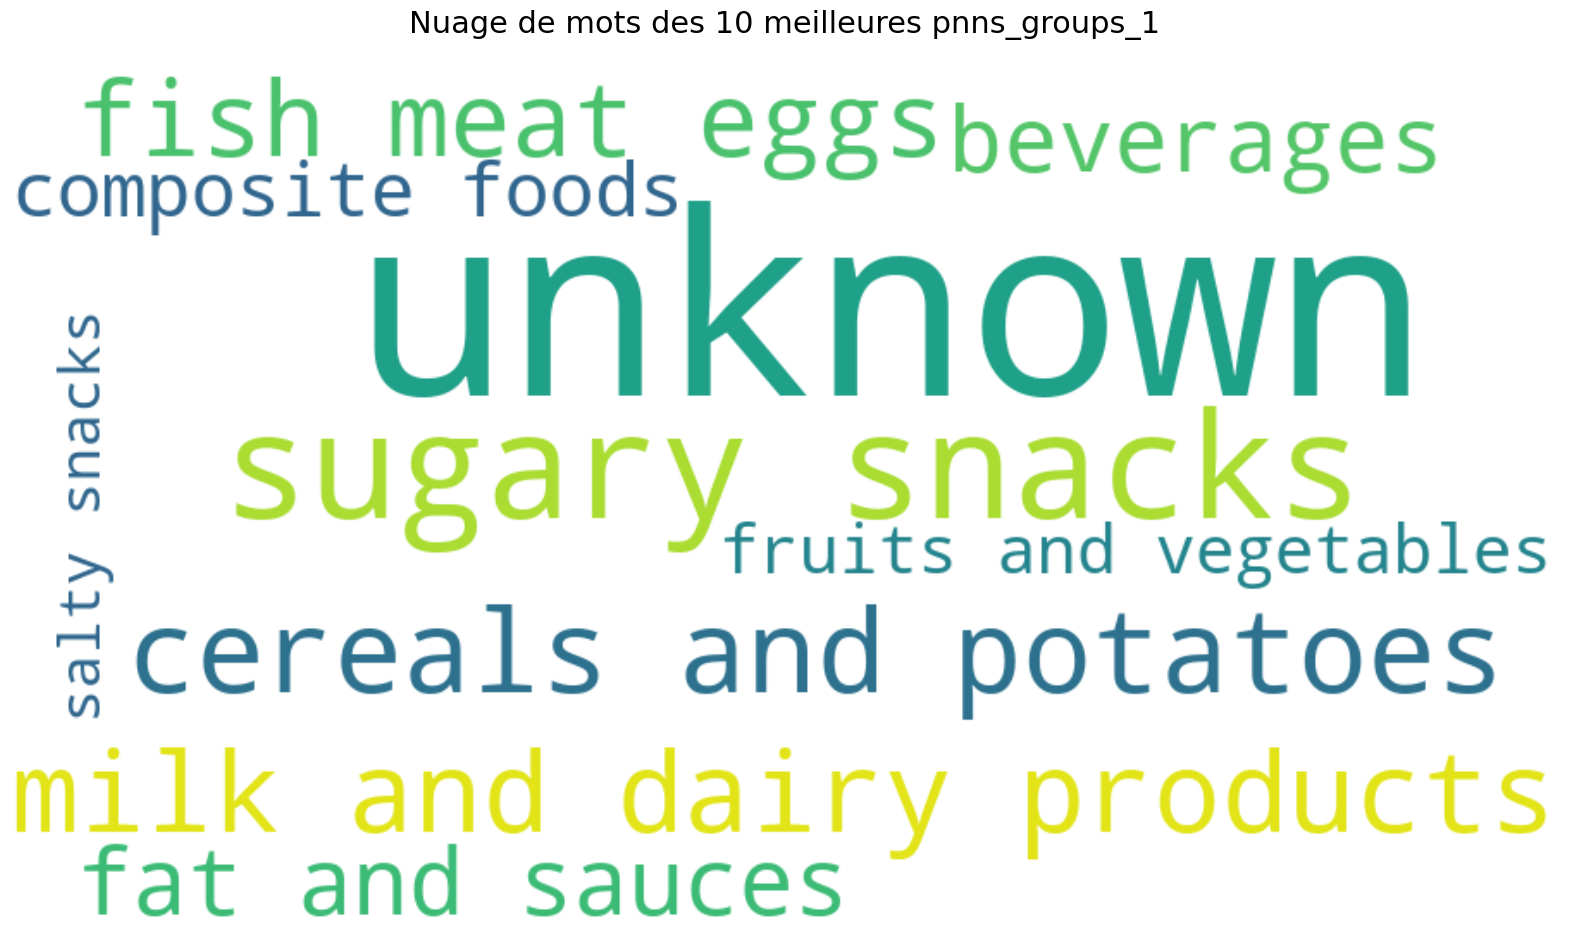

In [42]:
plot_world_cloud(df=datas,column="pnns_groups_1",nb_top=10)

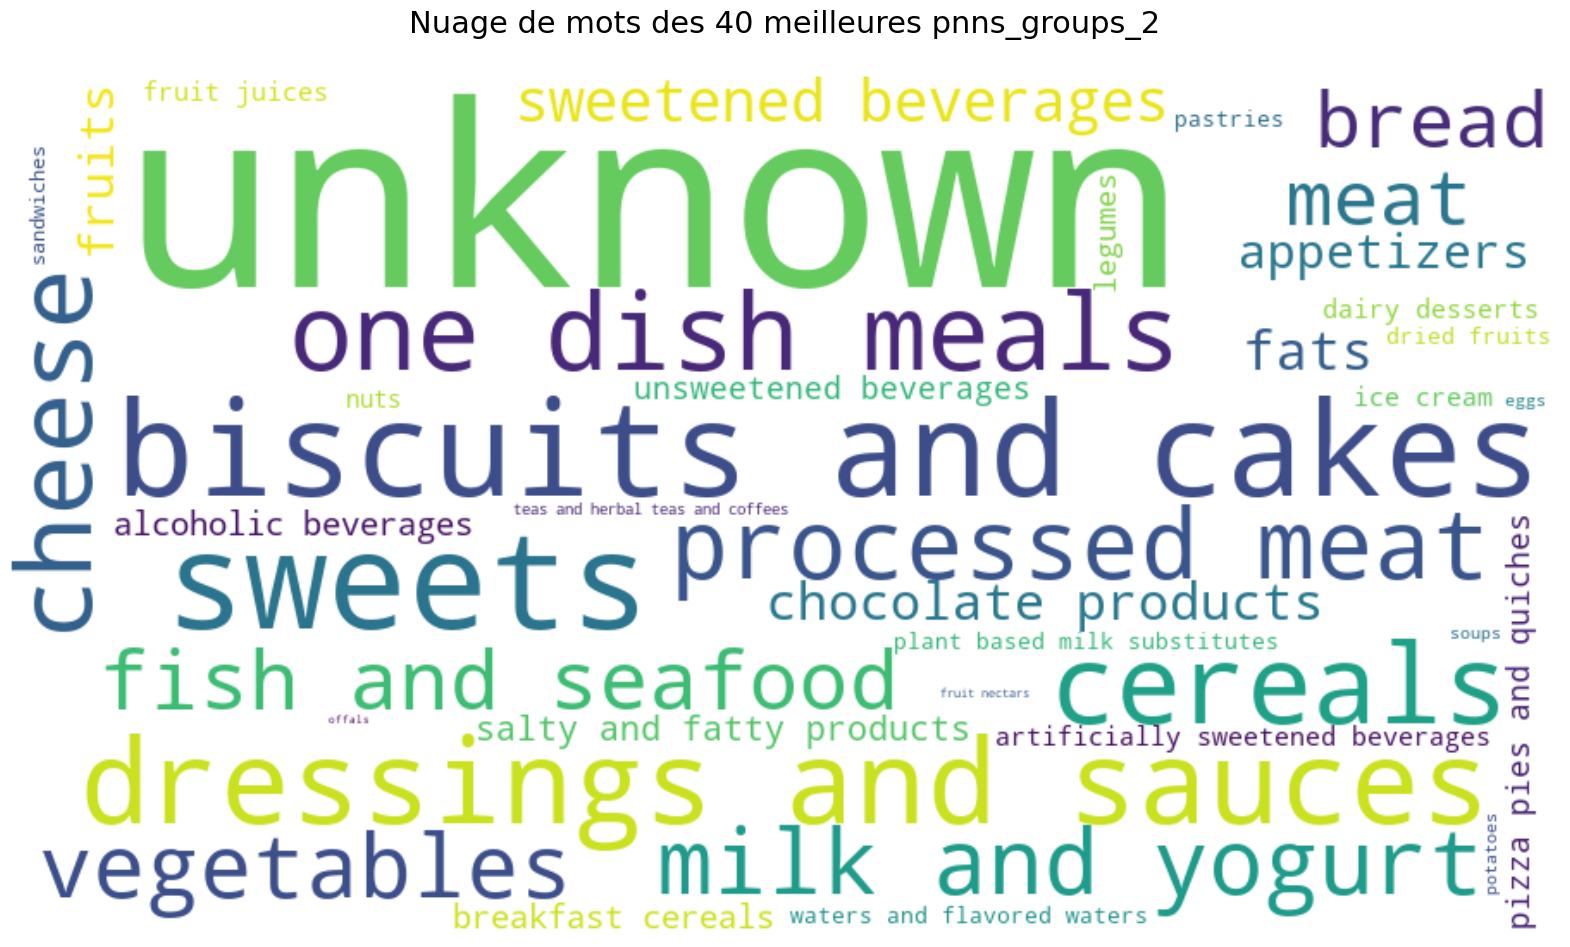

In [43]:
plot_world_cloud(df=datas,column="pnns_groups_2",nb_top=len(pnns_groups_2))

In [44]:
datas.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1877499 entries, 1 to 2830754
Columns: 165 entries, code to carnitine_100g
dtypes: float64(124), object(41)
memory usage: 2.3+ GB


### <font color="#ea1c60" id="section_5">1.5. Compléter les valeurs manquantes ou aberrantes</font>

Le jeu de données est nettoyé mais comme le montre les informations ci-dessus, il reste un grand nombre de valeurs manquantes qu'il va falloir compléter mais également des outliers à identifier.

Regardons dans un premier temps une rapide description du Dataset :

In [45]:
datas.describe()

serving_quantity    additives_n  nutriscore_score     nova_group   
count      4.989590e+05  723316.000000     753230.000000  641173.000000  \
mean       2.449814e+28       1.958678          9.192364       3.391380   
std        1.730476e+31       2.827394          8.679002       0.986667   
min        0.000000e+00       0.000000        -15.000000       1.000000   
25%        2.800000e+01       0.000000          2.000000       3.000000   
50%        5.600000e+01       1.000000         10.000000       4.000000   
75%        1.180000e+02       3.000000         16.000000       4.000000   
max        1.222357e+34      50.000000         40.000000       4.000000   

       ecoscore_score  product_quantity  unique_scans_n  completeness   
count    479401.00000      5.435820e+05   649343.000000  1.877497e+06  \
mean         48.90237      1.655708e+13        2.546171  4.802570e-01   
std          25.31537      1.220703e+16        6.794489  2.018555e-01   
min         -30.00000      0.000000e+00        1.000000  1.000000e-01   
25%          30.00000      1.500000e+02        1.000000  3.000000e-01   
50%          49.00000      2.800000e+02        1.000000  4.000000e-01   
75%          72.00000      5.000000e+02        2.000000  5.750000e-01   
max         125.00000      9.000000e+18      842.000000  1.100000e+00   

       energy-kj_100g  energy-kcal_100g  ...   
count    1.871710e+05      1.723938e+06  ...  \
mean     3.644603e+03      3.043754e+39  ...   
std      1.054156e+06      3.996413e+42  ...   
min      0.000000e+00     -5.300000e+01  ...   
25%      3.930000e+02      1.000000e+02  ...   
50%      9.900000e+02      2.590000e+02  ...   
75%      1.620000e+03      4.000000e+02  ...   
max      4.555600e+08      5.247243e+45  ...   

       carbon-footprint-from-meat-or-fish_100g  nutrition-score-fr_100g   
count                             11727.000000            753233.000000  \
mean                                608.323594                 9.192389   
std                                6118.394023                 8.678998   
min                                   0.049000               -15.000000   
25%                                 102.075000                 2.000000   
50%                                 310.800000                10.000000   
75%                                 606.800000                16.000000   
max                              656298.600000                40.000000   

       nutrition-score-uk_100g  glycemic-index_100g  water-hardness_100g   
count                 3.000000             6.000000                1.000  \
mean                 18.666667            40.950000                1.475   
std                   6.027714            18.779111                  NaN   
min                  13.000000            14.000000                1.475   
25%                  15.500000            32.250000                1.475   
50%                  18.000000            41.500000                1.475   
75%                  21.500000            47.525000                1.475   
max                  25.000000            70.000000                1.475   

       choline_100g  phylloquinone_100g  beta-glucan_100g  inositol_100g   
count     96.000000         1344.000000         52.000000      80.000000  \
mean       6.891693            0.087756          3.506346       1.921747   
std       43.472295            2.061522          2.775687      11.776487   
min        0.000000            0.000000          0.400000       0.001600   
25%        0.039025            0.000008          2.275000       0.008775   
50%        0.083000            0.000024          3.600000       0.024500   
75%        0.122500            0.000103          4.000000       0.051000   
max      390.000000           54.000000         20.000000      75.000000   

       carnitine_100g  
count       46.000000  
mean         0.024343  
std          0.083090  
min          0.000800  
25%          0.007000  
50%          0.011000  
75%          0.015000  
ma

On remarque déjà que les valeurs minimum et maximum de **certaines variables** (comme les nutriments ou la valeur energetique) **peuvent contenir des valeurs aberrantes**, ce qui impacte également l'écart-type et donc la variance.

In [46]:
datas[datas['energy_100g'] == datas['energy_100g'].max()]

code                                                url   
2432764  806001087994  http://world-en.openfoodfacts.org/product/8060...  \

        product_name abbreviated_product_name generic_name quantity   
2432764          NaN                      NaN          NaN      NaN  \

        packaging_en packaging_text brands categories_en  ...   
2432764          NaN            NaN    NaN       unknown  ...  \

        carbon-footprint-from-meat-or-fish_100g nutrition-score-fr_100g   
2432764                                     NaN                     NaN  \

        nutrition-score-uk_100g glycemic-index_100g water-hardness_100g   
2432764                     NaN                 NaN                 NaN  \

        choline_100g phylloquinone_100g beta-glucan_100g inositol_100g   
2432764          NaN                NaN              NaN           NaN  \

        carnitine_100g  
2432764            NaN  

[1 rows x 165 columns]

Ici, ce produit qui possède la plus grande valeur energétique n'est quasi pas complété. Le manque le nom du produit, les catégories et toutes les valeurs nutritionnelles. Nous allons **supprimer tous les produits qui n'ont ni nom, ni catégorie** et qui ne pourront donc être clairement identifiés.

In [47]:
datas_cleaned = datas[~((datas.product_name.isnull()) 
                        & ((datas.pnns_groups_1 == "unknown") 
                           | (datas.main_category_en == "unknown")))]

In [48]:
datas_cleaned[((datas_cleaned.pnns_groups_1 == "unknown") & (datas_cleaned.main_category_en == "unknown") &
              (datas_cleaned.pnns_groups_2 == "unknown") & (datas_cleaned.categories_en == "unknown"))].shape[0]

957513

Il reste tout de même **510 484 produits qui ne contiennent aucune indication de catégorie**.

Afin de pouvoir calculer des indicateurs empiriques correctes, nous allons remplacer par des valeurs nulles tous les max et min aberrants *(0, -1 ou 999999...)* :

In [49]:
#On repère les numerical_features
numerical_features = list(datas_cleaned.select_dtypes(include=["float64","int64"]).columns)
#On supprime les nutriscores qui eux peuvent être négatifs
numerical_features.remove('nutriscore_score')
numerical_features.remove('nutrition-score-fr_100g')
#numerical_features.remove('ingredients_that_may_be_from_palm_oil_n')
#numerical_features.remove('ingredients_from_palm_oil_n')
numerical_features.remove('nova_group')

In [50]:
#On supprime les lignes dont toutes les numerical_features sont à 0 ou nulles
datas_cleaned = datas_cleaned.loc[~((datas_cleaned[numerical_features]==0) | (datas_cleaned[numerical_features].isnull())).all(axis=1)]

In [51]:
#On supprime les lignes contenant des valeurs négatives et des max aberrants
datas_cleaned = datas_cleaned[~(datas_cleaned[numerical_features] < 0).any(axis=1)]
datas_cleaned = datas_cleaned[~(datas_cleaned[numerical_features].isin([999999,9999999])).any(axis=1)]

Les variables suffixées avec `_100g` nous indiquent la quantité de nutriment pour 100 grammes de produit. Les valeurs renseignées ne peuvent donc logiquement pas excéder 100. Nous allons donc **supprimer les lignes dont au moins 1 des variables de nutriments est supérieur au seuil** :

In [52]:
g_per_100g_features = ['proteins_100g','fat_100g','carbohydrates_100g','sugars_100g','salt_100g',
                       'sodium_100g','saturated-fat_100g','fiber_100g']
datas_cleaned = datas_cleaned[~(datas_cleaned[g_per_100g_features] > 100).any(axis=1)]

D'autre part, les valeurs de `saturated-fat_100g` ne peuvent pas être supérieurs à `fat_100g`, de même pour les valeurs de `sodium_100g` qui ne peuvent pas être supérieurs à `salt_100g`.     
Nous allons donc supprimer les lignes qui remplissent ces conditions :

In [53]:
datas_cleaned = datas_cleaned[~((datas_cleaned['saturated-fat_100g'] > datas_cleaned['fat_100g']) 
                                | (datas_cleaned['sodium_100g'] > datas_cleaned['salt_100g']))]

Enfin, les densité d'energie maximales pour 100g sont de 3700 kJ/100g *(source [Wikipedia](https://en.wikipedia.org/wiki/Food_energy))*. Nous allons donc supprimer toutes les lignes dont la variable `energy_100g` est supérieur à 3700 *(ou 900 kcal/100g)*.

In [54]:
datas_cleaned = datas_cleaned[~((datas_cleaned['energy_100g'] > 3700) 
                                | (datas_cleaned['energy-kcal_100g'] > 900))]

Pour les variables restantes, nous allons nous baser sur la médiane et l'écart-type pour éliminer les outliers. Commençons par afficher la dispersion des données et ces métriques :

In [55]:
sigma_features = ['additives_n','serving_quantity']

In [56]:
#On initialise l'écart-type et la médiane
sigma = [0 for _ in range(len(sigma_features))]
median = [0 for _ in range(len(sigma_features))]
#Puis on complètes les valeurs avec le dataset sans les valeurs nulles
for i in range(len(sigma_features)):
  median[i] = datas_cleaned[pd.notnull(datas_cleaned[sigma_features[i]])][sigma_features[i]].median()
  serie = datas_cleaned[pd.notnull(datas_cleaned[sigma_features[i]])][sigma_features[i]]
  serie = serie.sort_values()
  sigma[i] = np.std(serie[:-25])

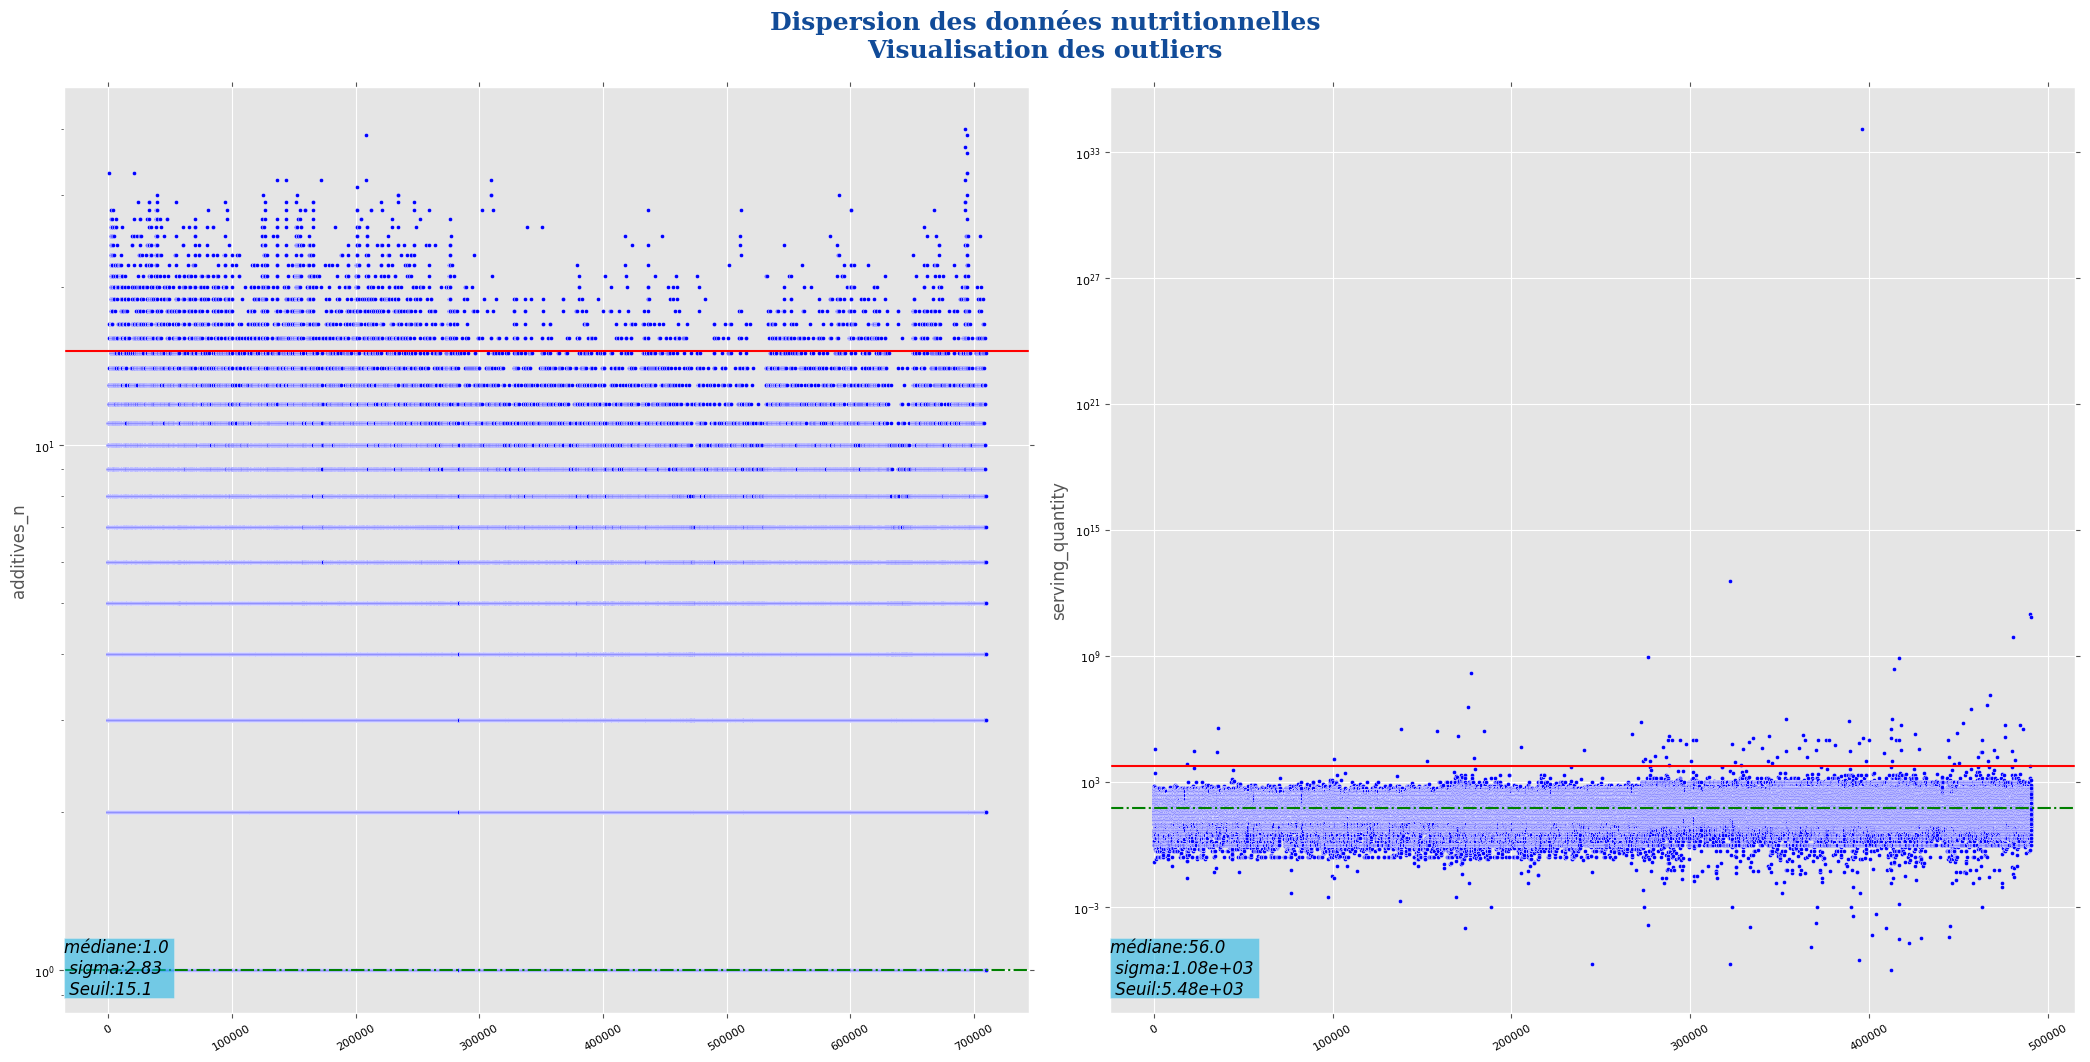

In [57]:
plt.style.use('ggplot')
tPlot, axes = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=False, figsize=(21,10))
axes = np.array(axes)

i=0
for ax in axes.reshape(-1):
    colonne = sigma_features[i]
    test = datas_cleaned[pd.notnull(datas_cleaned[colonne])][colonne]
    ax.tick_params(labelcolor='black',top='off',bottom='on',left='on',right='off',labelsize=8)
    ax.set_ylabel(colonne.rstrip("_100g"), fontsize = 12)
    ax.set_yscale("log")
    ax.plot(list(test), 'b.', markeredgewidth = 0.3, markeredgecolor='w')
    for tick in ax.get_xticklabels():
        tick.set_rotation(30)
    ax.axhline(y=median[i], color='g', linestyle='dashdot')
    ax.axhline(y=median[i] + 5*sigma[i], color='r', linestyle='-')
    ax.text(0., 0.02, 'médiane:{:.3} \n sigma:{:.3} \n Seuil:{:.3}'.format(median[i], sigma[i], (median[i] + 5*sigma[i])),
            style='italic', transform=ax.transAxes, fontsize = 12,
            bbox={'facecolor':'#00afe6', 'alpha':0.5, 'pad':0})
    i += 1

tPlot.text(0.5, 1.01, r"Dispersion des données nutritionnelles" "\n" "Visualisation des outliers", ha='center', fontdict=font_title)
plt.tight_layout()

Ces représentations nous indiquent clairement les éventuels **outliers qui diffèrent de la valeur médiane de plus de 5 fois l'écart-type ($5\sigma$ - valeur sélectionnée après plusieurs essais)**.

In [58]:
for i in range(len(sigma_features)):
    col = sigma_features[i]
    threshold = (median[i] + 5*sigma[i])
    print('{:30}: suppression de la ligne si valeur > {}'.format(col, round(threshold,3)))
    mask = datas_cleaned[col] > threshold
    datas_cleaned = datas_cleaned.drop(datas_cleaned[mask].index)

additives_n                   : suppression de la ligne si valeur > 15.132
serving_quantity              : suppression de la ligne si valeur > 5478.266


In [60]:
datas_cleaned.shape

(1839301, 165)

In [59]:
datas_cleaned.describe()

serving_quantity    additives_n  nutriscore_score     nova_group   
count     488015.000000  706210.000000     736305.000000  625802.000000  \
mean          98.014233       1.897376          9.146615       3.398006   
std          121.910002       2.601677          8.683497       0.982886   
min            0.000000       0.000000        -15.000000       1.000000   
25%           28.000000       0.000000          2.000000       3.000000   
50%           56.000000       1.000000         10.000000       4.000000   
75%          120.000000       3.000000         16.000000       4.000000   
max         5466.000000      15.000000         40.000000       4.000000   

       ecoscore_score  product_quantity  unique_scans_n  completeness   
count   463763.000000      5.320260e+05   633949.000000  1.839299e+06  \
mean        50.364535      1.691671e+13        2.554324  4.805143e-01   
std         23.968535      1.233889e+16        6.821446  2.016320e-01   
min          0.000000      0.000000e+00        1.000000  2.000000e-01   
25%         33.000000      1.500000e+02        1.000000  3.000000e-01   
50%         49.000000      2.800000e+02        1.000000  4.000000e-01   
75%         72.000000      5.000000e+02        2.000000  5.750000e-01   
max        125.000000      9.000000e+18      842.000000  1.100000e+00   

       energy-kj_100g  energy-kcal_100g  ...   
count   182854.000000      1.692661e+06  ...  \
mean      1081.631216      2.665285e+02  ...   
std        776.881186      1.851770e+02  ...   
min          0.000000      0.000000e+00  ...   
25%        392.000000      1.000000e+02  ...   
50%        990.000000      2.570000e+02  ...   
75%       1621.000000      3.980000e+02  ...   
max       3700.000000      9.000000e+02  ...   

       carbon-footprint-from-meat-or-fish_100g  nutrition-score-fr_100g   
count                             11354.000000            736308.000000  \
mean                                581.952659                 9.146641   
std                                6203.653781                 8.683492   
min                                   0.049000               -15.000000   
25%                                  98.420000                 2.000000   
50%                                 298.900000                10.000000   
75%                                 592.000000                16.000000   
max                              656298.600000                40.000000   

       nutrition-score-uk_100g  glycemic-index_100g  water-hardness_100g   
count                 2.000000             6.000000                1.000  \
mean                 15.500000            40.950000                1.475   
std                   3.535534            18.779111                  NaN   
min                  13.000000            14.000000                1.475   
25%                  14.250000            32.250000                1.475   
50%                  15.500000            41.500000                1.475   
75%                  16.750000            47.525000                1.475   
max                  18.000000            70.000000                1.475   

       choline_100g  phylloquinone_100g  beta-glucan_100g  inositol_100g   
count     95.000000         1333.000000         52.000000      77.000000  \
mean       6.962553            0.047970          3.506346       1.021399   
std       43.697345            1.449568          2.775687       8.542680   
min        0.000000            0.000000          0.400000       0.001600   
25%        0.038050            0.000008          2.275000       0.006900   
50%        0.079000            0.000024          3.600000       0.024000   
75%        0.119000            0.000103          4.000000       0.051000   
max      390.000000           51.600000         20.000000      75.000000   

       carnitine_100g  
count       45.000000  
mean         0.024716  
std          0.083990  
min          0.000800  
25%          0.007000  
50%          0.011000  
75%          0.015000  
ma

Après ces quelques opérations de nettoyage, les valeurs médianes, d'écarts-type, de minimum et maximum sont plus cohérentes. Nous allons pouvoir exploiter ces données pour **estimer les valeurs manquantes**.

Nous allons déjà regarder la **distribution de ces variables et définir si elles suivent une loi normale**, ce qui nous aidera à prendre une décision pour la méthode d'imputation des valeurs manquantes.

ValueError: num must be an integer with 1 <= num <= 12, not 13

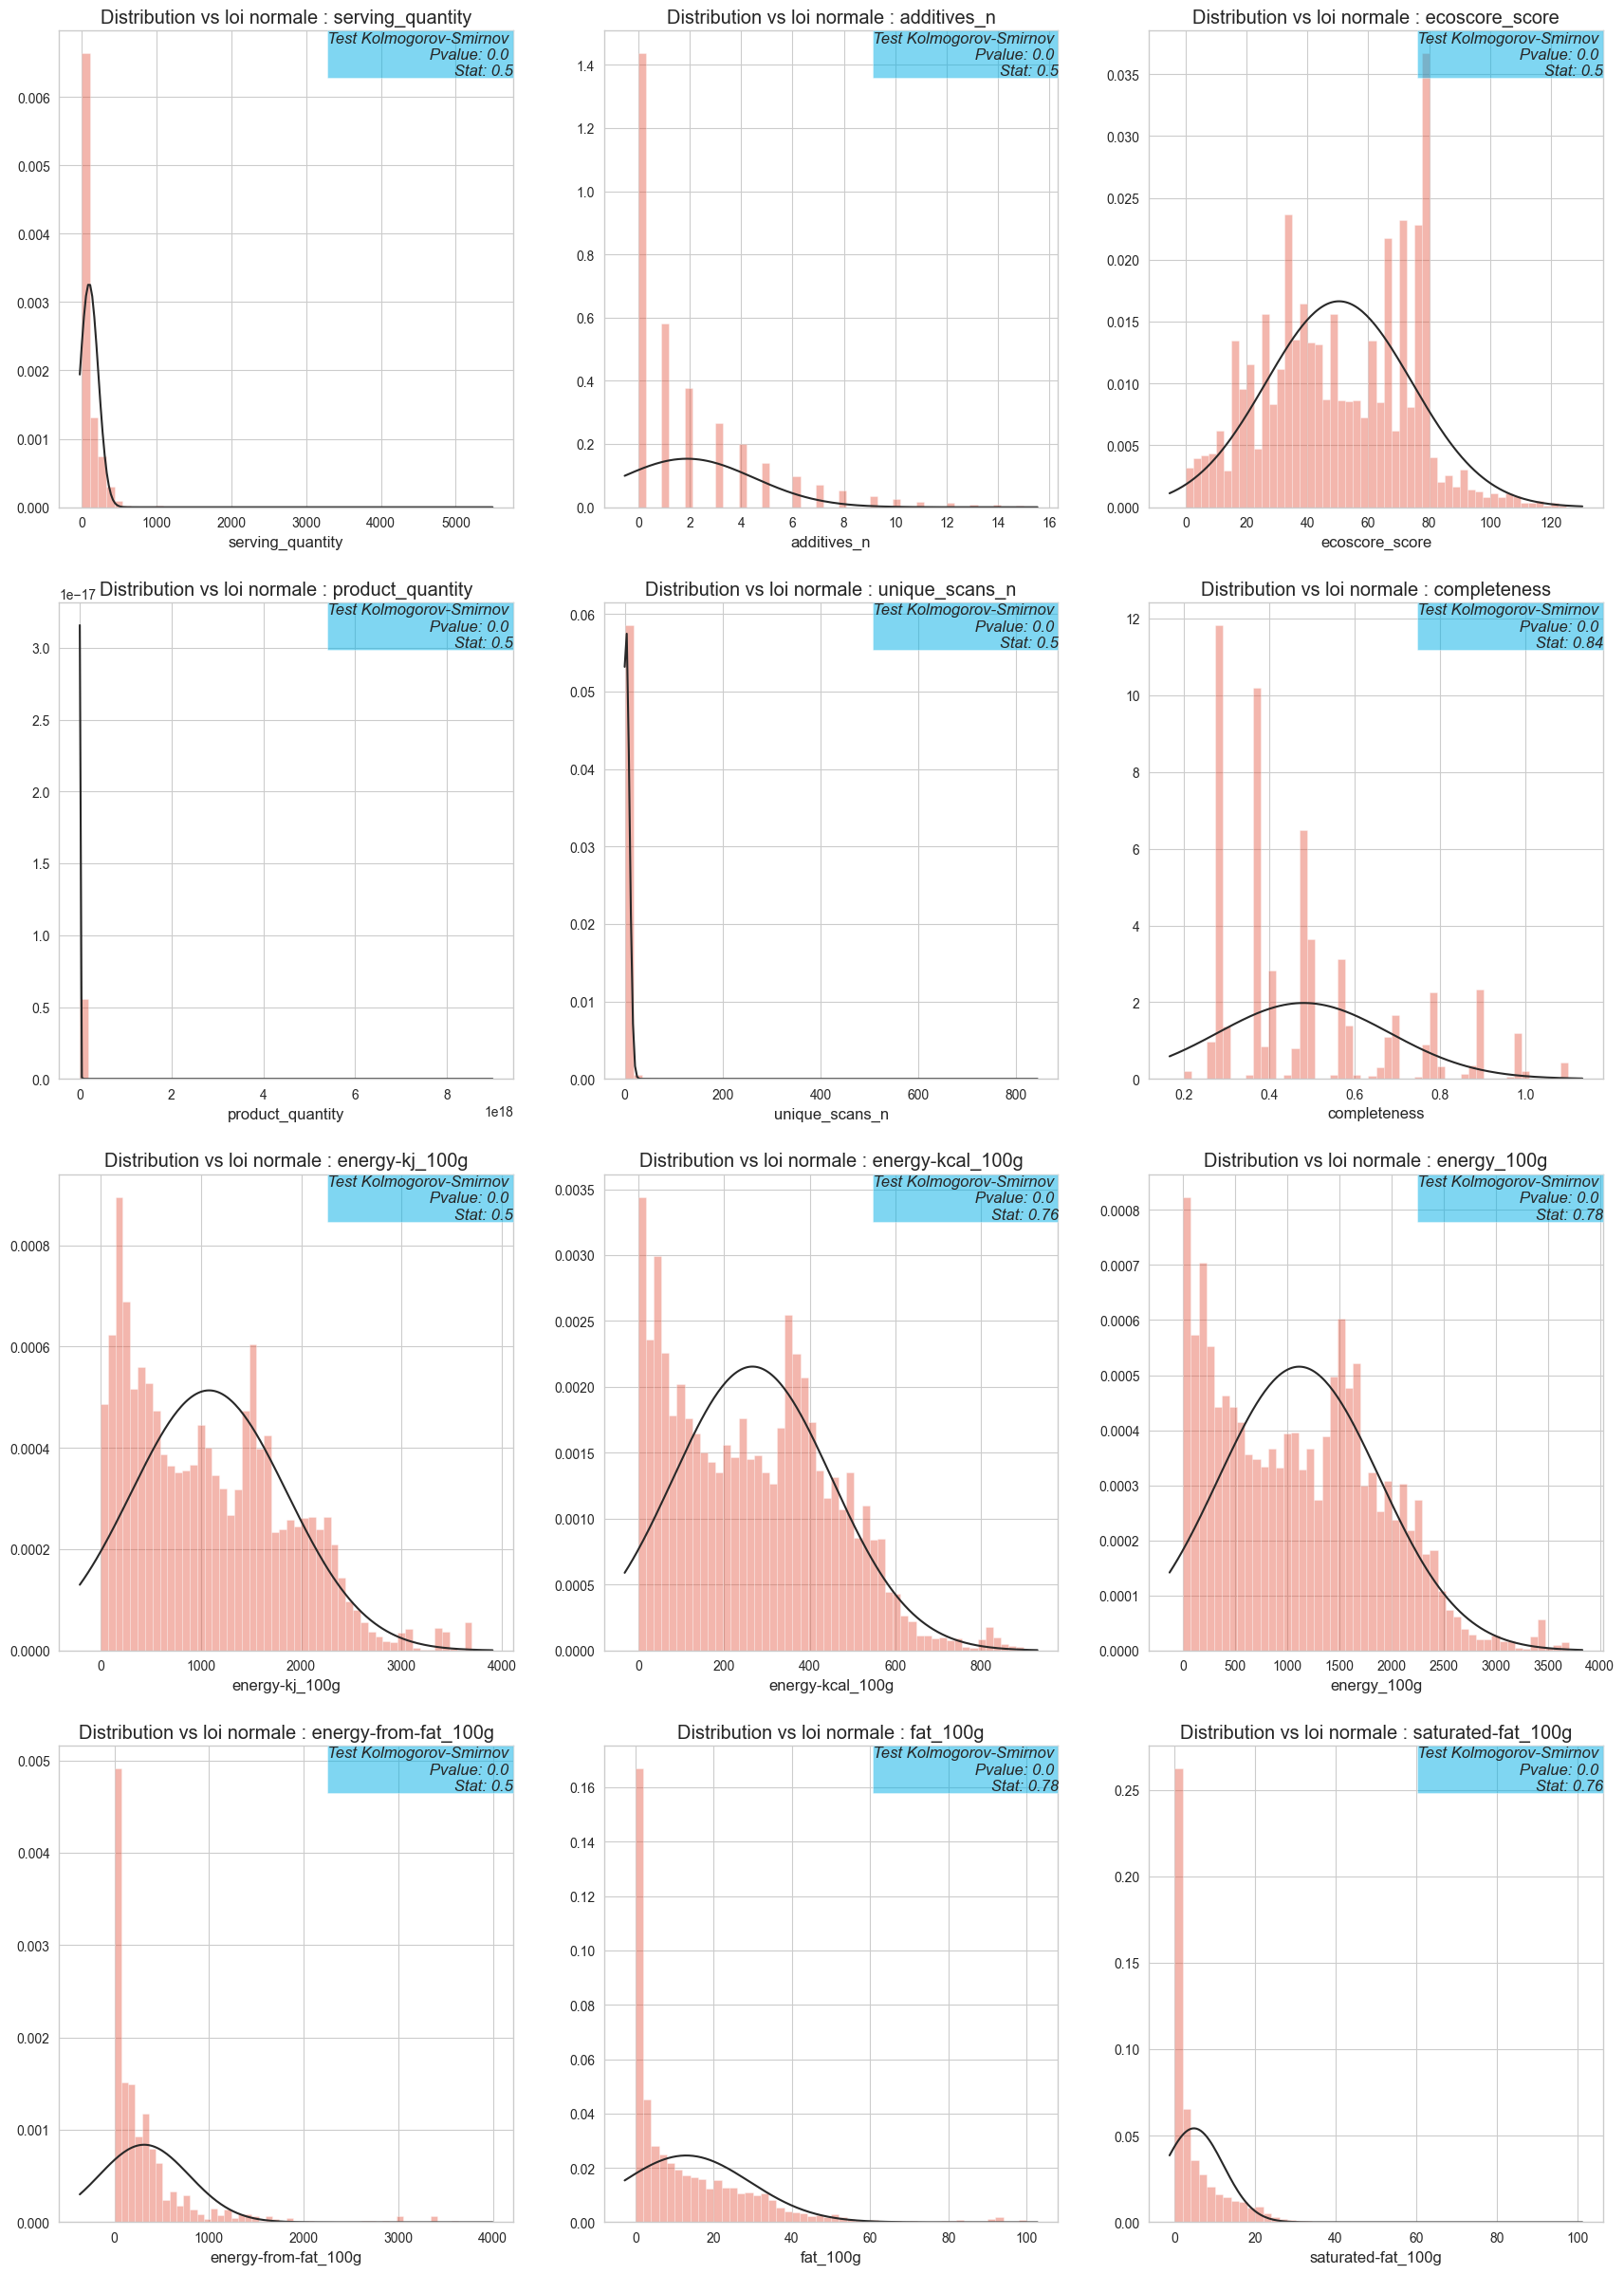

In [61]:
import scipy.stats as stats
import warnings

warnings.filterwarnings('ignore')
sns.set_style("whitegrid")
fig = plt.figure(figsize=(21, 30))

sub = 0
for i in range(len(numerical_features)):
    colonne = numerical_features[i]
    if datas_cleaned[colonne].nunique() > 1:
        # Tracé de la distribution
        fig.add_subplot(4, 3, sub+1)

        left, width = 0, 1
        bottom, height = 0, 1
        right = left + width
        top = bottom + height

        kstest = stats.kstest(datas_cleaned[colonne].notnull(), 'norm')
        ax = sns.distplot(datas_cleaned[colonne], fit=stats.norm, kde=False)
        ax.set_title("Distribution vs loi normale : {}".format(colonne))
        ax.text(right, top, 'Test Kolmogorov-Smirnov \n Pvalue: {:.2} \n Stat: {:.2}'.format(kstest.pvalue, kstest.statistic),
                horizontalalignment='right',
                verticalalignment='top',
                style='italic', transform=ax.transAxes, fontsize=12,
                bbox={'facecolor': '#00afe6', 'alpha': 0.5, 'pad': 0})
        sub += 1
    else:
        print("La colonne {} ne contient pas suffisamment de données pour être tracée.".format(colonne))

plt.show()


En se basant sur les projections obtenus et les résultats des tests de Kolmogorov-Smirnov (Pvalue < au niveau de test de 5%) **on rejette donc l'hypothèse de normalité des distributions de ces variables**. Il serait donc inexacte d'imputer les valeurs manquantes par la moyenne.

Pour confirmer cette approche, regardons à présent quelque unes de ces distributions en fonction de la catégorie `pnns_groups_1` :

ValueError: num must be an integer with 1 <= num <= 12, not 13

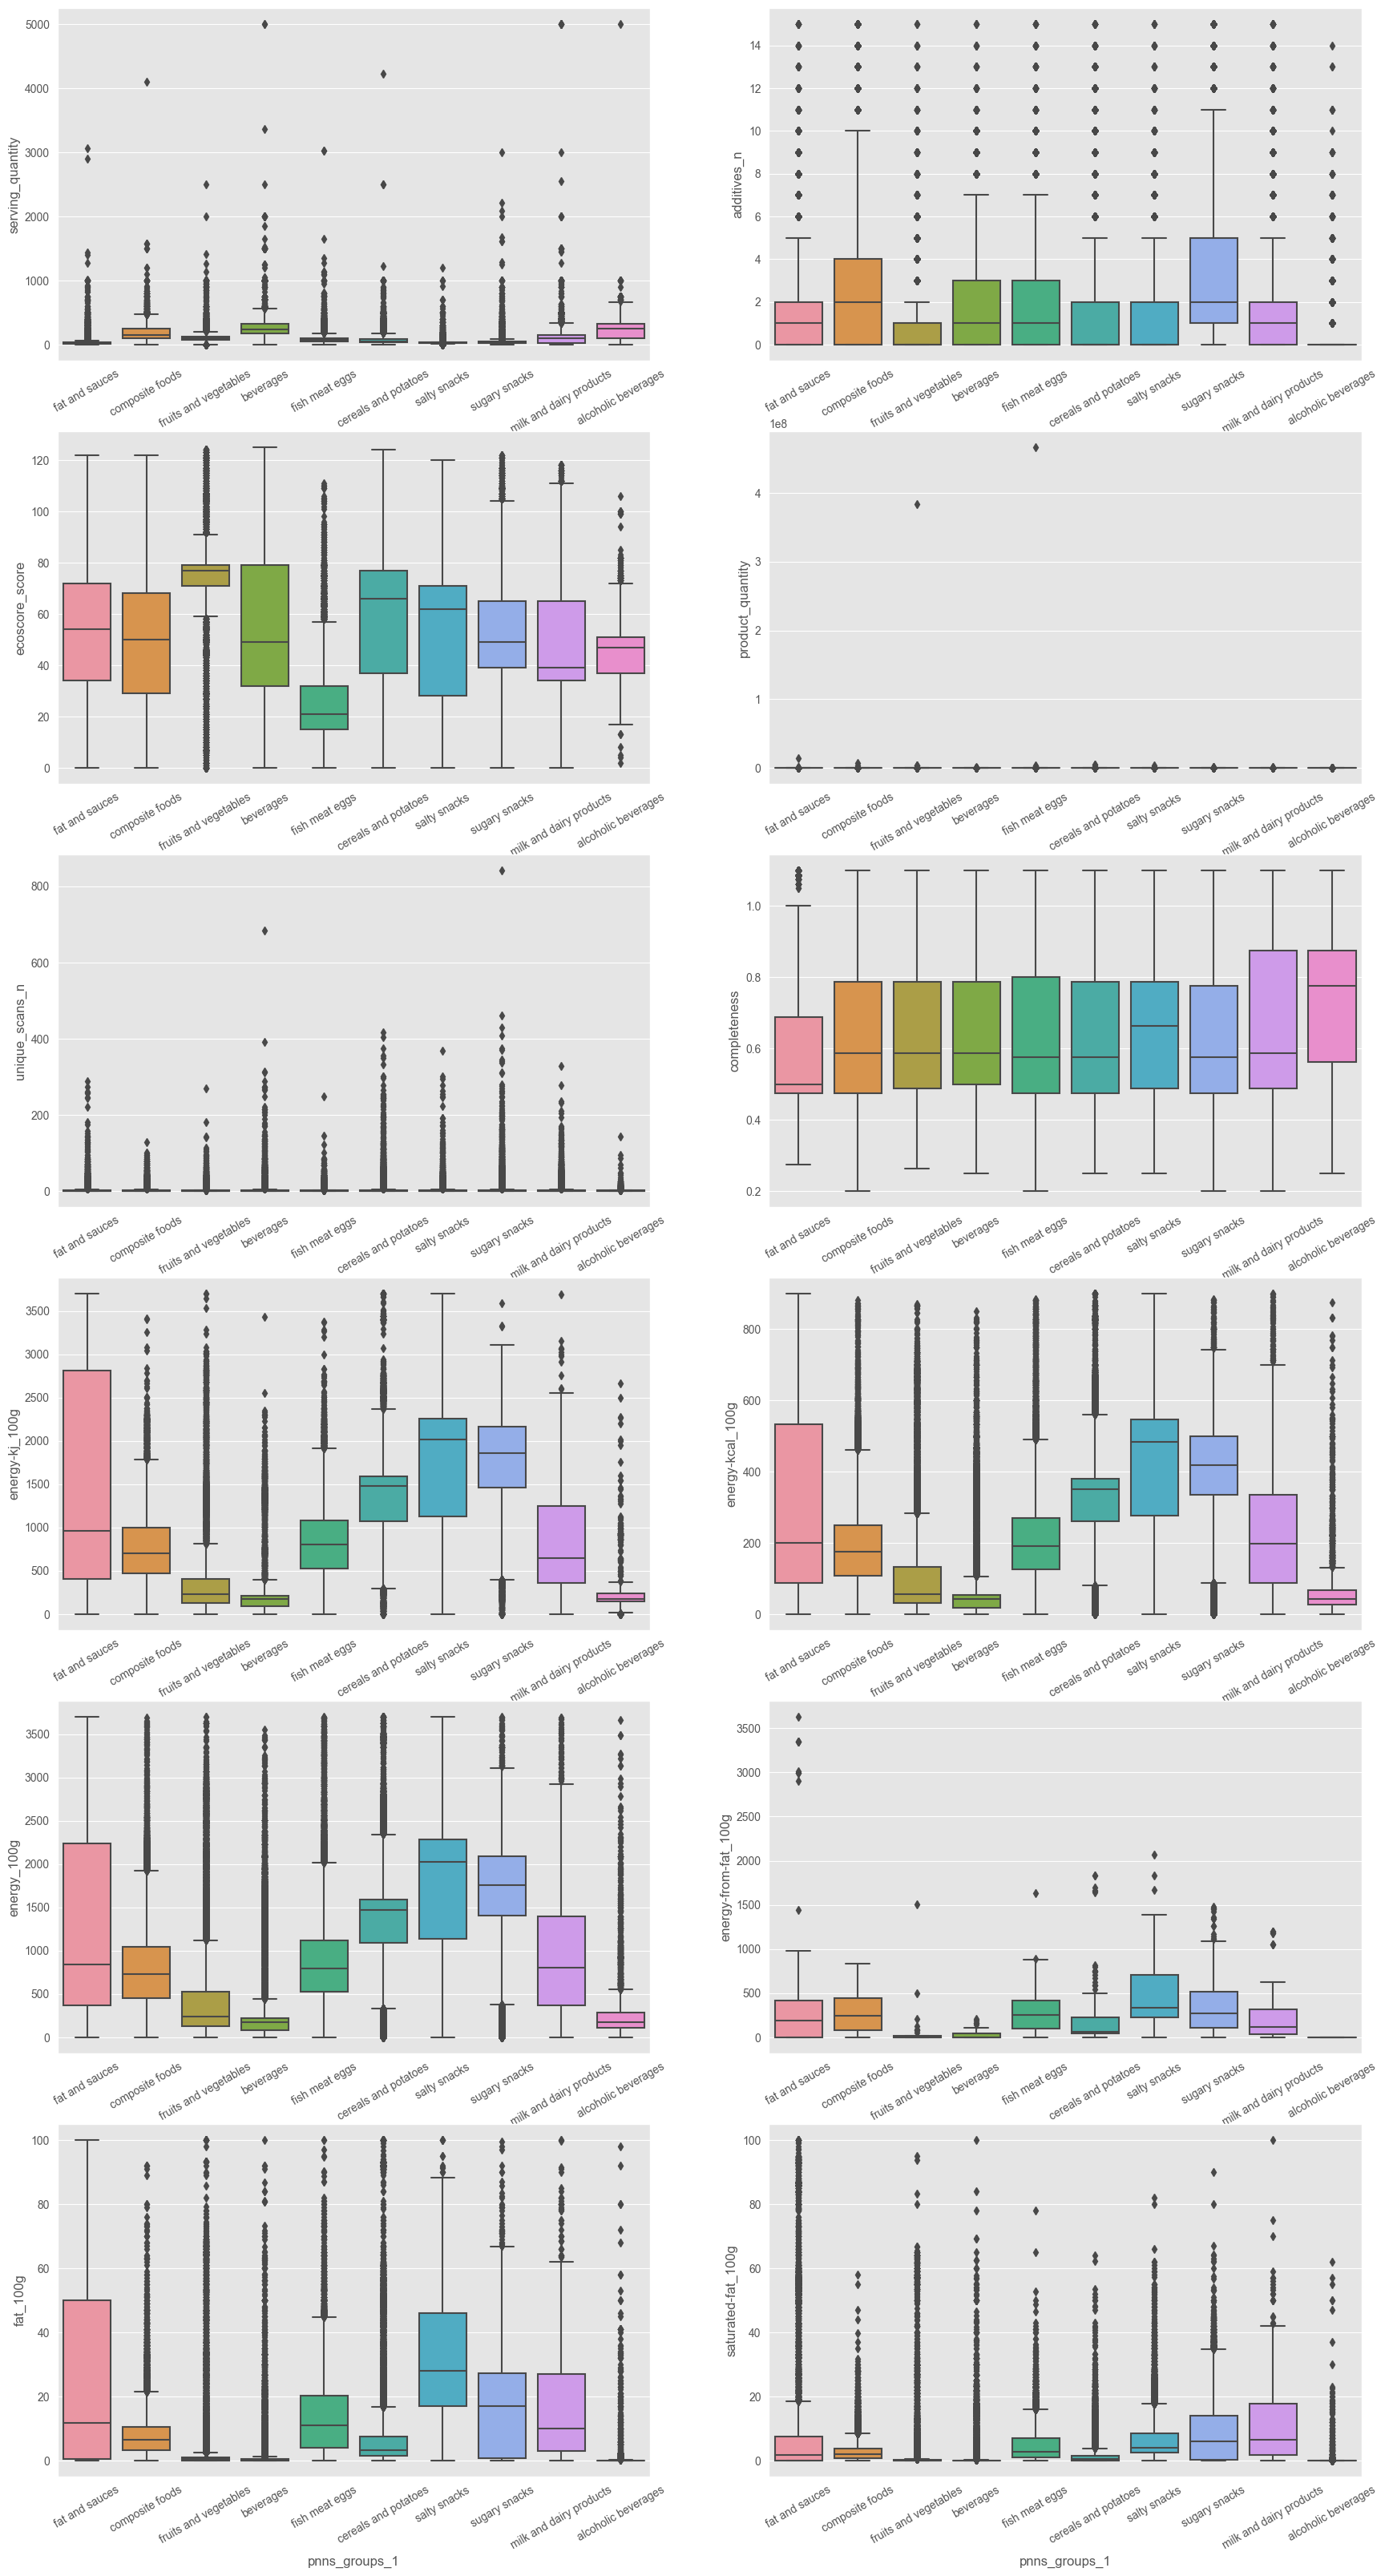

In [62]:
plt.style.use('ggplot')
fig = plt.figure(figsize=(21,40))

sub = 0
for i in range(len(numerical_features)):
    fig.add_subplot(6,2,i+1)
    colonne = numerical_features[i]
    ax = sns.boxplot(x="pnns_groups_1", y=colonne, data=datas_cleaned[datas_cleaned["pnns_groups_1"]!="unknown"])
    for tick in ax.get_xticklabels():
        tick.set_rotation(30)
    sub += 1

fig.text(0.5, 0.90, r"Distribution des variables nutritionnelles" "\n" "par catégories pnns_groups_1", ha="center", 
         fontdict=font_title)
plt.show()

Si l'on regarde la distribution de quelques unes de ces mêmes variables sur la catégorie `pnns_groups_2` :

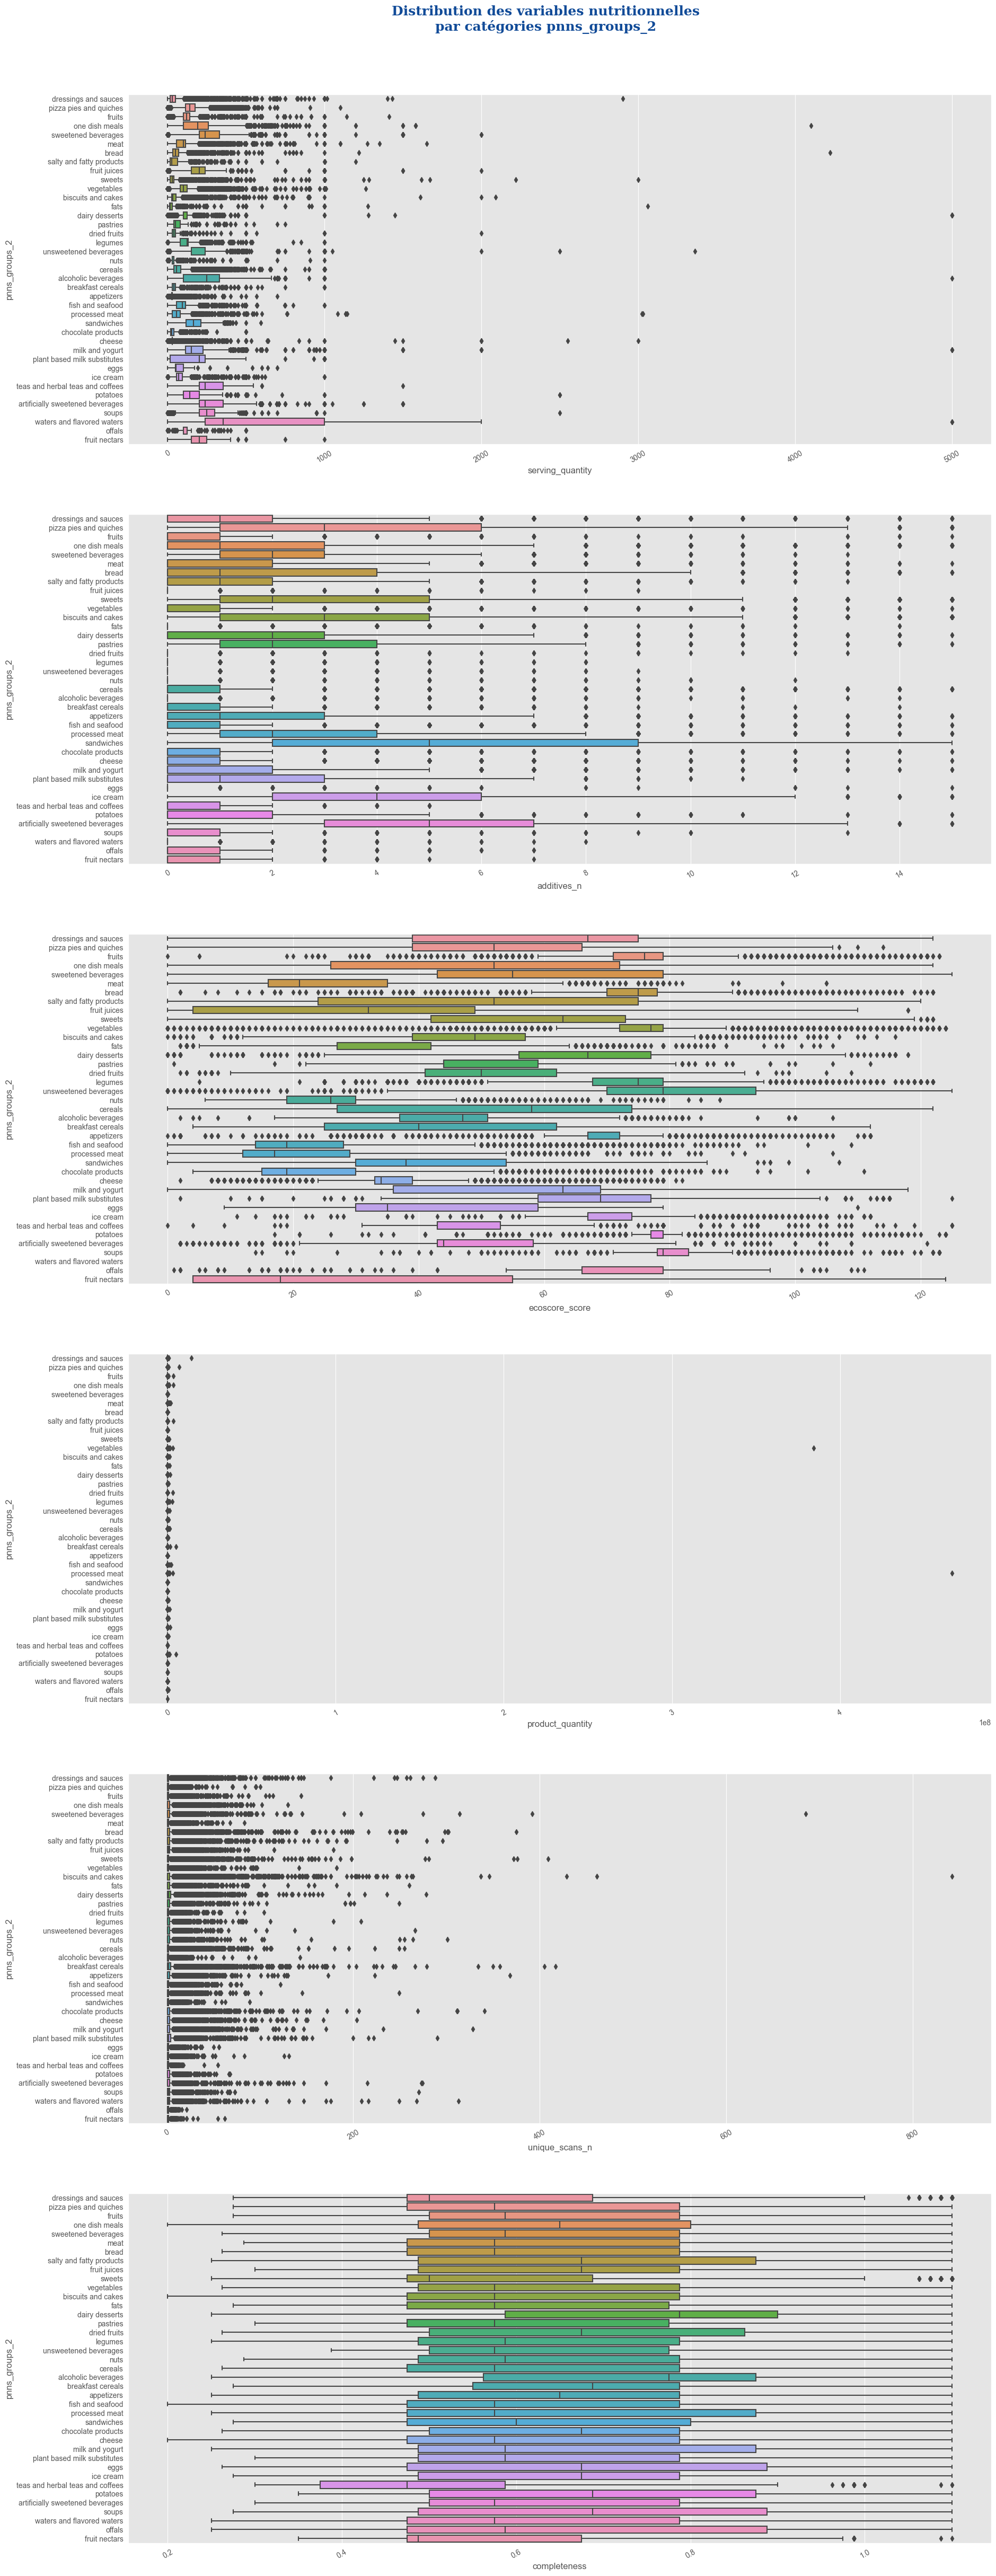

In [63]:
plt.style.use('ggplot')
fig = plt.figure(figsize=(21,60))

sub = 0
for i in range(len(numerical_features[:6])):
    fig.add_subplot(6,1,i+1)
    colonne = numerical_features[i]
    ax = sns.boxplot(y="pnns_groups_2", x=colonne, data=datas_cleaned[datas_cleaned["pnns_groups_2"]!="unknown"])
    for tick in ax.get_xticklabels():
        tick.set_rotation(30)
    sub += 1

fig.text(0.5, 0.90, r"Distribution des variables nutritionnelles" "\n" "par catégories pnns_groups_2", ha="center", 
         fontdict=font_title)
plt.show()

In [64]:
datas_cleaned[numerical_features].isnull().sum()

serving_quantity      1351286
additives_n           1133091
ecoscore_score        1375538
product_quantity      1307275
unique_scans_n        1205352
                       ...   
choline_100g          1839206
phylloquinone_100g    1837968
beta-glucan_100g      1839249
inositol_100g         1839224
carnitine_100g        1839256
Length: 121, dtype: int64

Pour ces valeurs nulles ci-dessus, les variables `serving_quantity` et `additives_n` sont très peu renseignées, nous allons donc les supprimer de notre jeu de données.     
`fiber_100g` est également mal renseigné mais nous en aurons besoin pour la suite. Nous allons donc compléter les valeurs nulles par la **médiane de la catégorie** `pnns_groups_2`.     
Enfin, pour les autres variables, avec peu de null et dont les distributions ne suivent pas la loi gaussiene, nous allons imputer avec l'**algorithme des K Nearest Neighbours** (KNN).

In [65]:
#On supprime les 2 colonnes les moins complétées et la variable redondante energie
datas_cleaned.drop(['serving_quantity','additives_n','energy-kcal_100g'], axis=1, inplace=True)

In [66]:
numerical_features.remove('serving_quantity')
numerical_features.remove('additives_n')
numerical_features.remove('energy-kcal_100g')

In [67]:
# KNN pour les autres variables
from sklearn.impute import KNNImputer

# On entraine le modèle d'imputation sur un échantillon de données
knn_features = ['energy_100g','proteins_100g','saturated-fat_100g','sugars_100g','salt_100g']
sample_datas = datas_cleaned[knn_features].sample(frac=0.25, random_state=1)
imputer = KNNImputer(n_neighbors=5, missing_values=np.nan)
imputer.fit(sample_datas)

KNNImputer()

In [68]:
# Puis on applique le modèle sur l'ensemble des données
datas_imputed = imputer.transform(datas_cleaned[knn_features])
df_datas_imputed = pd.DataFrame(datas_imputed, columns=knn_features)

In [69]:
for col_knn in knn_features:
    datas_cleaned[col_knn] = df_datas_imputed[col_knn].values

In [70]:
# On complète les variables restantes avec la médiane du groupe pnns 2
for col in ['carbohydrates_100g','sodium_100g','fat_100g','fiber_100g']:
    datas_cleaned[col] = datas_cleaned.groupby('pnns_groups_2')[col].transform(lambda x: x.fillna(x.median()))

Les valeurs manquantes étant à présent toutes complétées pour ces variables numériques, nous allons vérifier que les distributions n'ont pas changées :

ValueError: num must be an integer with 1 <= num <= 9, not 10

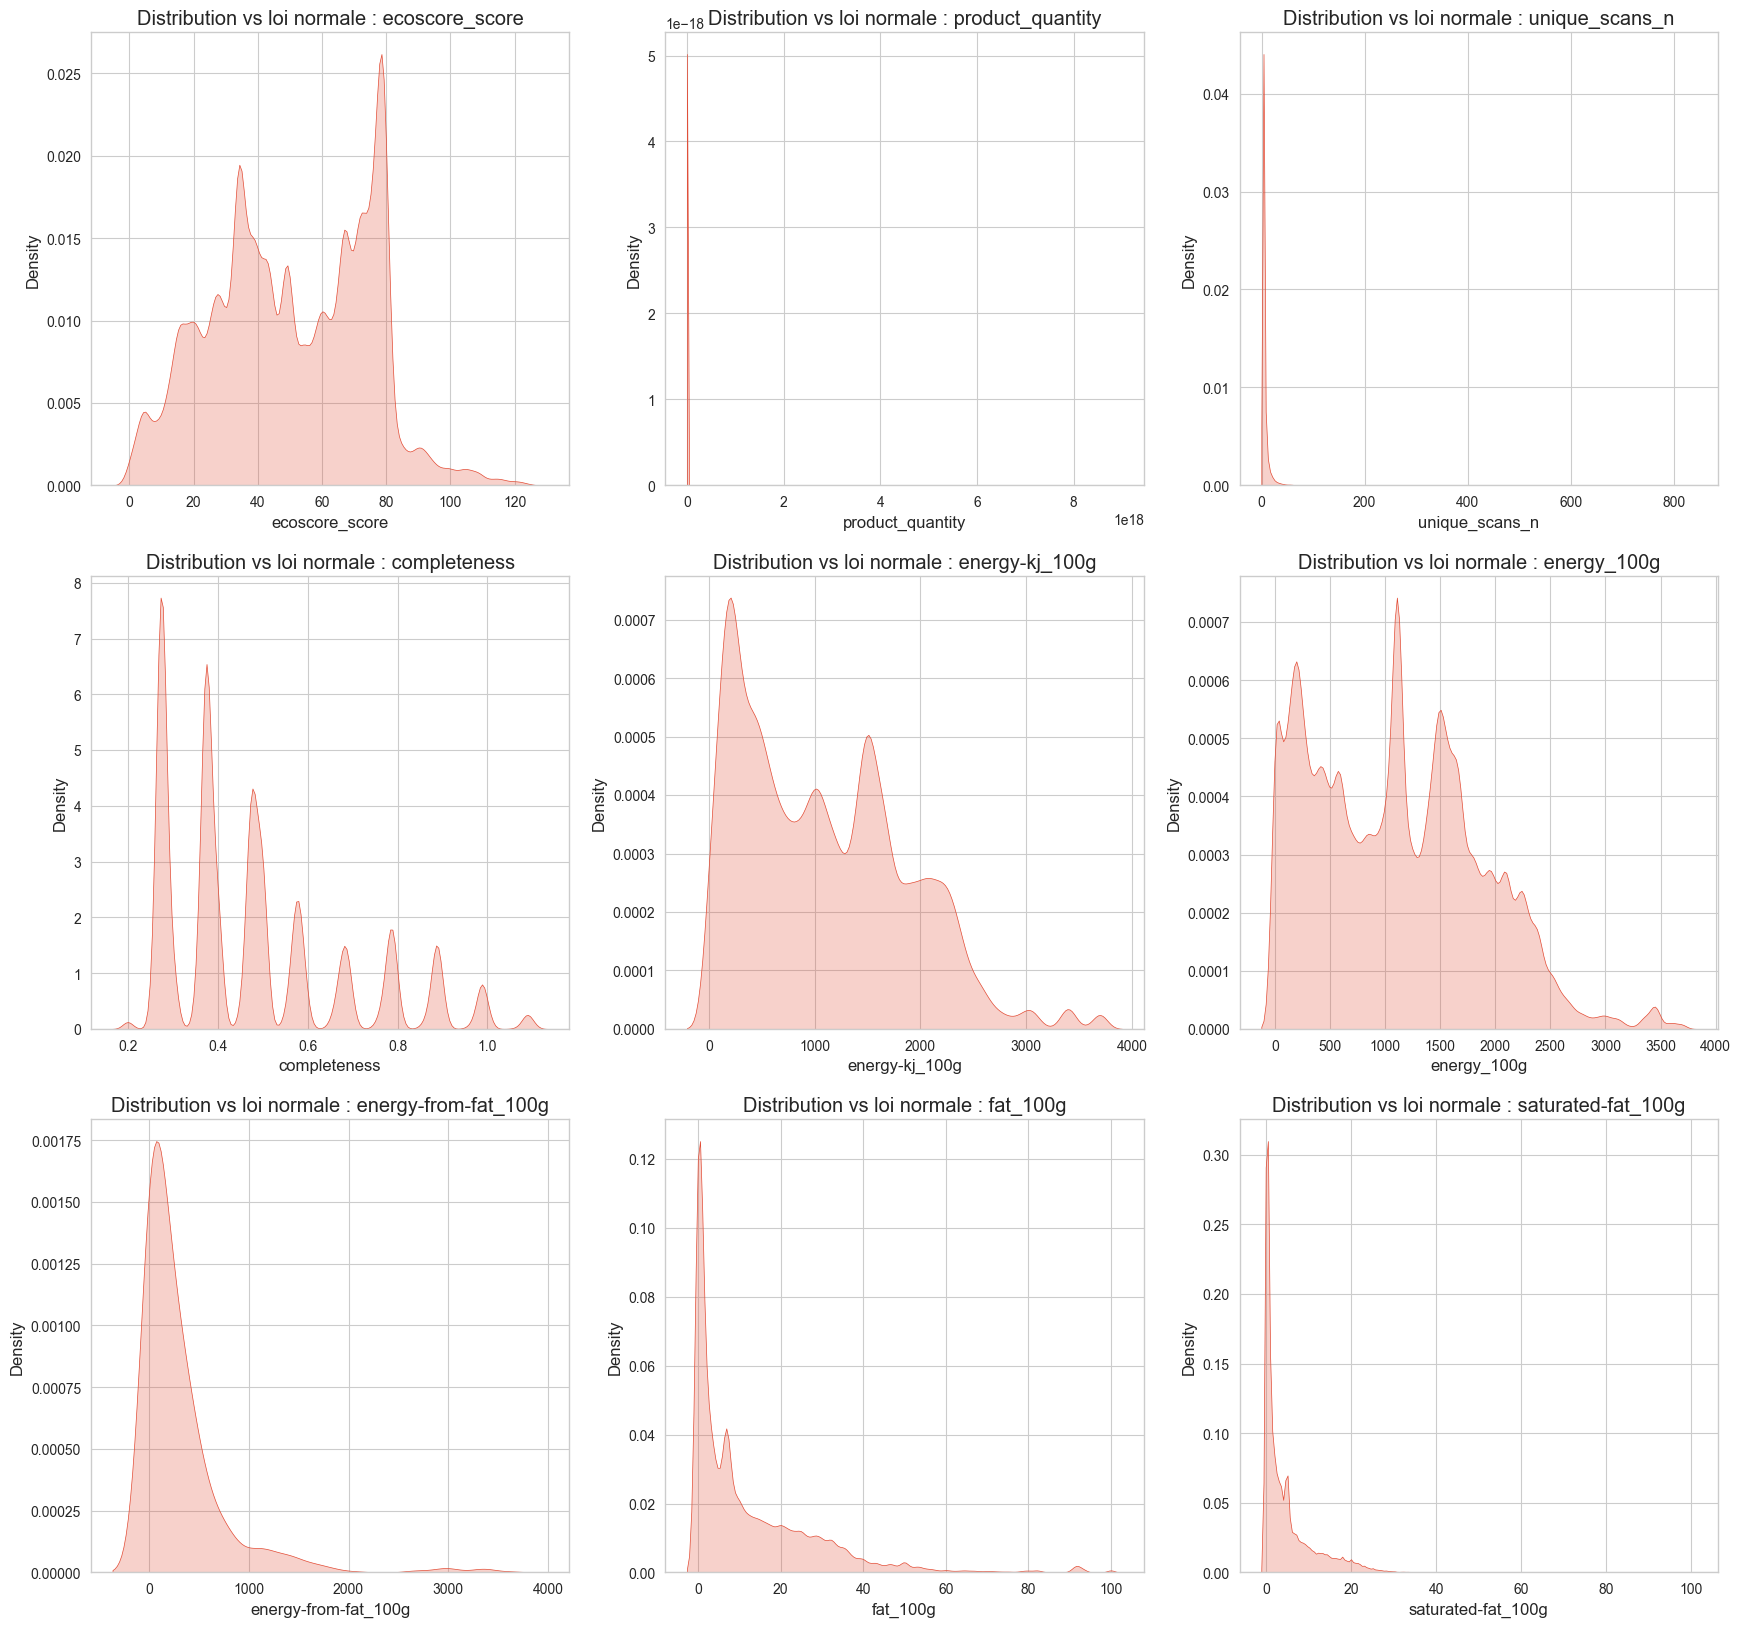

In [71]:
sns.set_style("whitegrid")
fig = plt.figure(figsize=(21,20))

sub = 0
for i in range(len(numerical_features)):
    colonne = numerical_features[i]
    if datas_cleaned[colonne].notnull().sum() > 1:  # Vérifie qu'il y a au moins 2 données non manquantes
        fig.add_subplot(3,3,sub+1)
        kstest = stats.kstest(datas_cleaned[colonne].notnull(),'norm')
        ax = sns.kdeplot(datas_cleaned[colonne].dropna(), shade=True)
        ax.set_title("Distribution vs loi normale : {}".format(colonne))
        sub += 1

plt.show()


Les variables imputées étant bien distribuées conformément aux variables d'origine, nous allons à présent **supprimer les dernières variables non pertinentes**, peu renseignées ou inutiles dans nos futurs modèles :

In [73]:
datas_cleaned.isnull().sum().sort_values(ascending=False)

water-hardness_100g        1839300
nutrition-score-uk_100g    1839299
chlorophyl_100g            1839297
elaidic-acid_100g          1839296
glycemic-index_100g        1839295
                            ...   
saturated-fat_100g               0
fat_100g                         0
energy_100g                      0
main_category_en                 0
code                             0
Length: 162, dtype: int64

In [74]:
deleted_features = ['brands','serving_size','nova_group','image_ingredients_small_url','ingredients_text','image_nutrition_small_url','image_small_url', 'nutrition-score-fr_100g','quantity']
datas_cleaned.drop(deleted_features, axis=1, inplace=True)

### <font color="#ea1c60" id="section_6">1.6. Calcul des Nutri-Scores manquants</font>

Une des variables primoridale de ce jeu de données est le Nutriscore. Or, cette variable compte beaucoup de manquants. 
Afin de calculer ce nutriscore, nous avons besoin de plusieurs autres variables.

Le score prend en comptepour 100g de produit, la teneur :
- En nutriments et aliments à favoriser (fibres, protéines, fruits et légumes),
- En nutriments à limiter (énergie, acide gras saturés, sucres, sel).

Après calcul, le score obtenu par un produit permet de lui attribuer une lettre et une couleur.
Voici un tableau simplifié permettant de calculer l'attribution des points :

<table width="100%" style="border:solid 1px; text-align:center;" align="center">
    <thead style="border:solid 1px; text-align:center;">
        <th bgcolor="#feadb3"><b>Points</b></th>
        <th bgcolor="#feadb3">Energie (kJ)</th>
        <th bgcolor="#feadb3">Sucres simples (g)</th>
        <th bgcolor="#feadb3">Acide gras saturés (g)</th>
        <th bgcolor="#feadb3">Sodium (mg)</th>
        <th bgcolor="#b6faa3"><b>Points</b></th>
        <th bgcolor="#b6faa">Fruits,leg(%)</th>
        <th bgcolor="#b6faa">Fibres (g)</th>
        <th bgcolor="#b6faa">Protéines (g)</th>
    </thead>
    <tbody>
        <tr>
            <td bgcolor="#feadb3"><b>0</b></td>
            <td bgcolor="#feadb3">$\leq$ 335</td>
            <td bgcolor="#feadb3">$\leq$ 4,5</td>
            <td bgcolor="#feadb3">$\leq$ 1</td>
            <td bgcolor="#feadb3">$\leq$ 90</td>
            <td bgcolor="#b6faa"><b>0</b></td>
            <td bgcolor="#b6faa">$\leq$ 40</td>
            <td bgcolor="#b6faa">$\leq$ 0,7</td>
            <td bgcolor="#b6faa">$\leq$ 1,6</td>
        </tr>
        <tr>
            <td bgcolor="#feadb3"><b>5</b></td>
            <td bgcolor="#feadb3">$>$ 335</td>
            <td bgcolor="#feadb3">$>$ 4,5</td>
            <td bgcolor="#feadb3">$>$ 1</td>
            <td bgcolor="#feadb3">$>$ 90</td>
            <td bgcolor="#b6faa"><b>-2</b></td>
            <td bgcolor="#b6faa">$>$ 40</td>
            <td bgcolor="#b6faa">$>$ 0,7</td>
            <td bgcolor="#b6faa">$>$ 1,6</td>
        </tr>
        <tr>
            <td bgcolor="#feadb3"><b>10</b></td>
            <td bgcolor="#feadb3">$>$ 1675</td>
            <td bgcolor="#feadb3">$>$ 22,5</td>
            <td bgcolor="#feadb3">$>$ 5</td>
            <td bgcolor="#feadb3">$>$ 450</td>
            <td bgcolor="#b6faa"><b>-5</b></td>
            <td bgcolor="#b6faa">$>$ 80</td>
            <td bgcolor="#b6faa">$>$ 3,5</td>
            <td bgcolor="#b6faa">$>$ 8</td>
        </tr>
        <tr style="border:solid 1px; text-align:center;">
            <td> </td>
            <td>(a)</td>
            <td>(b)</td>
            <td>(c)</td>
            <td>(d)</td>
            <td> </td>
            <td>(e)</td>
            <td>(f)</td>
            <td>(g)</td>
        </tr>
        <tr>
            <td><b>Total</b></td>
            <td colspan="8"><b>(a) + (b) + (c) + (d) + (e) + (f) + (g)</b></td>
        </tr>
    </tbody>
</table>

Attribution des classes *(version simplifiée)* :

<table width="50%" style="border:solid 1px; text-align:center;" align="center">
    <thead>
        <th>Aliment solide</th>
        <th>Lettre</th>
        <th>Couleur</th>
    </thead>
    <tbody>
        <tr>
            <td>Mimimum -1</td>
            <td>A</td>
            <td>Vert foncé</td>
        </tr>
        <tr>
            <td>0 à 5</td>
            <td>B</td>
            <td>Vert</td>
        </tr>
        <tr>
            <td>5 à 10</td>
            <td>C</td>
            <td>Jaune</td>
        </tr>
        <tr>
            <td>10 à 20</td>
            <td>D</td>
            <td>Orange</td>
        </tr>
        <tr>
            <td>20 et plus</td>
            <td>E</td>
            <td>Orange foncé</td>
        </tr>
    </tbody>
</table>

Nous allons donc **isoler les variables nécessaires au calcul du Nutriscore et vérifier leur taux de remplissage** :

In [75]:
nutriscore_features = ['pnns_groups_1', 'pnns_groups_2', 'nutriscore_grade', 'nutriscore_score',
                       'energy_100g','sugars_100g','saturated-fat_100g','sodium_100g', 'fiber_100g', 'proteins_100g']
datas_cleaned[nutriscore_features].sample(10)

pnns_groups_1       pnns_groups_2 nutriscore_grade   
2758566         unknown             unknown              NaN  \
1718315  fish meat eggs                meat                d   
2174407         unknown             unknown              NaN   
1658366         unknown             unknown                d   
1147179   sugary snacks  biscuits and cakes                e   
1170889   sugary snacks              sweets                c   
529082          unknown             unknown              NaN   
711086          unknown             unknown              NaN   
605151   fat and sauces                fats                c   
2458091   sugary snacks  biscuits and cakes                d   

         nutriscore_score  energy_100g  sugars_100g  saturated-fat_100g   
2758566               NaN        146.0         5.48            0.100000  \
1718315              15.0        845.0         1.60            4.000000   
2174407               NaN        854.0        14.00           15.000000   
1658366              15.0       1368.0        53.00            0.100000   
1147179              19.0       1896.0        37.00            7.200000   
1170889              10.0          4.0        95.00            0.000000   
529082                NaN        359.0         8.00            1.714286   
711086                NaN       1255.0        20.00            0.000000   
605151                6.0       3586.0         0.00           14.285714   
2458091              15.0       1761.0        29.00            3.000000   

         sodium_100g  fiber_100g  proteins_100g  
2758566     0.640000    1.851852       1.000000  
1718315     7.200000    0.000000       1.000000  
2174407     0.048000    1.851852       3.300000  
1658366     0.180000    1.851852       2.100000  
1147179     0.088000    1.100000       5.500000  
1170889     0.000000    0.950000       0.000000  
529082      0.048571    0.571429       5.142857  
711086      0.300000    1.851852       0.000000  
605151      0.000000    0.000000       0.000000  
2458091     0.200000    2.600000       5.000000

La variable indiquant la proportion de fruit/légumes des produits a été supprimée car très peu renseignée. Nous allons donc tenter de l'estimer en fonction de la catégorie :

In [76]:
datas_cleaned.pnns_groups_2.unique()

array(['unknown', 'dressings and sauces', 'pizza pies and quiches',
       'fruits', 'one dish meals', 'sweetened beverages', 'meat', 'bread',
       'salty and fatty products', 'fruit juices', 'sweets', 'vegetables',
       'biscuits and cakes', 'fats', 'dairy desserts', 'pastries',
       'dried fruits', 'legumes', 'unsweetened beverages', 'nuts',
       'cereals', 'alcoholic beverages', 'breakfast cereals',
       'appetizers', 'fish and seafood', 'processed meat', 'sandwiches',
       'chocolate products', 'cheese', 'milk and yogurt',
       'plant based milk substitutes', 'eggs', 'ice cream',
       'teas and herbal teas and coffees', 'potatoes',
       'artificially sweetened beverages', 'soups',
       'waters and flavored waters', 'offals', 'fruit nectars'],
      dtype=object)

In [77]:
high_rate_fruit = ['fruit juices','dried fruits','legumes','vegetables','fruits', 'soups','potatoes','fruit nectars']

medium_rate_fruit = ['unknown', 'sweetened beverages', 'dressings and sauces', 'ice cream', 'pastries', 'dairy desserts',
                     'pizza pies and quiche', 'pizza pies and quiches']

low_rate_fruit = ['waters and flavored waters','chocolate products', 'fish and seafood', 'salty and fatty products', 
                  'cheese', 'cereals', 'appetizers', 'one dish meals', 'bread', 'fats', 'plant based milk substitutes',
                  'alcoholic beverages', 'processed meat', 'breakfast cereals', 'meat', 'eggs', 'sandwiches',
                  'offals', 'teas and herbal teas and coffees', 'biscuits and cakes', 'sweets', 'milk and yogurt',
                  'artificially sweetened beverages', 'unsweetened beverages','nuts']

In [78]:
datas_cleaned['fruits-vegetables-rate_100g'] = [81 if cat in high_rate_fruit else 45 if cat in medium_rate_fruit else 25 for cat in datas_cleaned.pnns_groups_2]

A présent, nous allons définir la **fonction de calcul du Nutriscore** et l'appliquer à notre dataset :

In [79]:
def calc_globalscore(row):
    #Energy
    if row["energy_100g"] <= 335:
        a = 0
    elif ((row["energy_100g"] > 335) & (row["energy_100g"] <= 1675)):
        a = 5
    else:
        a = 10 
    #Sugar
    if row["sugars_100g"] <= 4.5:
        b = 0
    elif ((row["sugars_100g"] > 4.5) & (row["sugars_100g"] <= 22.5)):
        b = 5
    else:
        b = 10
    #saturated-fat
    if row["saturated-fat_100g"] <= 1:
        c = 0
    elif ((row["saturated-fat_100g"] > 1) & (row["saturated-fat_100g"] <= 5)):
        c = 5
    else:
        c = 10
    #sodium
    if (row["sodium_100g"]/1000) <= 90:
        d = 0
    elif (((row["sodium_100g"]/1000) > 90) & ((row["sodium_100g"]/1000) <= 450)):
        d = 5
    else:
        d = 10
    #fruits-vegetables-rate
    if row["fruits-vegetables-rate_100g"] <= 40:
        e = 0
    elif ((row["fruits-vegetables-rate_100g"] > 40) & (row["fruits-vegetables-rate_100g"] <= 80)):
        e = -2
    else:
        e = -5
    #fiber
    if row["fiber_100g"] <= 0.7:
        f = 0
    elif ((row["fiber_100g"] > 0.7) & (row["fiber_100g"] <= 3.5)):
        f = -2
    else:
        f = -5
    #proteins
    if row["proteins_100g"] <= 1.6:
        g = 0
    elif ((row["proteins_100g"] > 1.6) & (row["proteins_100g"] <= 8)):
        g = -2
    else:
        g = -5
    
    #Global_score
    global_score = a+b+c+d+e+f+g
    
    return global_score

In [80]:
#Nutriscore
def calc_nutriscore(row):
    if row["calc_global_score"] < 0 :
        nutriscore = "a"
    elif ((row["calc_global_score"] >= 0) & (row["calc_global_score"] < 5)) :
        nutriscore = "b"
    elif ((row["calc_global_score"] >= 5) & (row["calc_global_score"] < 10)) :
        nutriscore = "c"
    elif ((row["calc_global_score"] >= 10) & (row["calc_global_score"] < 20)) :
        nutriscore = "d"
    else:
        nutriscore = "e"
        
    return nutriscore

In [81]:
datas_cleaned['calc_global_score'] = datas_cleaned.apply(lambda row: calc_globalscore(row),axis=1)
datas_cleaned['calc_nutriscore'] = datas_cleaned.apply(lambda row: calc_nutriscore(row),axis=1)

In [82]:
nutriscore_features.append('calc_global_score')
nutriscore_features.append('calc_nutriscore')

In [83]:
datas_cleaned[nutriscore_features].sample(10)

pnns_groups_1             pnns_groups_2 nutriscore_grade   
2391840           fat and sauces      dressings and sauces              NaN  \
291753                 beverages       sweetened beverages              NaN   
1609791     cereals and potatoes         breakfast cereals                b   
157315             sugary snacks                    sweets                d   
868398   milk and dairy products           milk and yogurt                b   
674252             sugary snacks        biscuits and cakes                d   
1579416                  unknown                   unknown              NaN   
2163253  milk and dairy products           milk and yogurt                d   
2630407                  unknown                   unknown              NaN   
1922193             salty snacks  salty and fatty products                c   

         nutriscore_score  energy_100g  sugars_100g  saturated-fat_100g   
2391840               NaN        669.0    35.100000            0.000000  \
291753                NaN        176.0    10.420000            0.000000   
1609791               0.0       1470.0     1.100000            1.300000   
157315               14.0       1360.0    45.000000            0.000000   
868398                2.0        377.0    12.000000            1.900000   
674252               13.0       1904.0    22.727273            2.272727   
1579416               NaN       2205.0    43.300000           16.600000   
2163253              14.0       1423.0     3.000000           20.700000   
2630407               NaN        114.0     0.950000            0.050000   
1922193              10.0       1641.0     0.800000            5.100000   

         sodium_100g  fiber_100g  proteins_100g  calc_global_score   
2391840     0.028000    0.500000       1.000000                 13  \
291753      0.015000    0.000000       0.000000                  3   
1609791     0.008000    7.500000      13.500000                  0   
157315      0.100000    0.950000       5.000000                 11   
868398      0.044000    0.000000       3.500000                 13   
674252      0.136364    2.600000       0.454545                 23   
1579416     0.192000    1.851852       5.200000                 24   
2163253     0.040000    0.000000       2.500000                 13   
2630407     0.268000    1.851852       1.220000                 -4   
1922193     0.600000   11.000000       9.800000                  5   

        calc_nutriscore  
2391840               d  
291753                b  
1609791               b  
157315                d  
868398                d  
674252                e  
1579416               e  
2163253               d  
2630407               a  
1922193               c

Nous devons à présent **vérifier les erreurs d'imputation sur les scores déjà connus**, ce qui nous permettra de voir si les calculs sont satisfaisants et utilisables :

In [84]:
df_scores = datas_cleaned[['nutriscore_grade', 'nutriscore_score', 'calc_nutriscore', 'calc_global_score']][datas_cleaned['nutriscore_grade'].isnull()==False]

from sklearn.metrics import accuracy_score

accuracy_nutrigrade = accuracy_score(df_scores['nutriscore_grade'].values, df_scores['calc_nutriscore'].values)
print("L'accuracy_score sur les Nutrigrades calculés est de : {:.2f} %.".format(accuracy_nutrigrade*100))

L'accuracy_score sur les Nutrigrades calculés est de : 47.47 %.


La précision du calul est donc inférieure à 50%. **Ces calculs ne peuvent donc pas être utilisés pour compléter nos données**.     **<font color="green">Notre application aura donc pour but d'éstimer le nutrigrade d'un produit en fonction de ses caractéristiques connues, comme la catégorie, sa teneur en nutriments ... grâce à des algorithmes simples de Machine Learning</font>**. 

In [85]:
datas_cleaned.drop(['calc_nutriscore','calc_global_score'], axis=1, inplace=True)

In [86]:
datas_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1839301 entries, 1 to 2830754
Columns: 154 entries, code to fruits-vegetables-rate_100g
dtypes: float64(119), int64(1), object(34)
memory usage: 2.1+ GB


Les variables sont à présent filtrées et les données nettoyées et complétées. Nous allons sauvegarder le dataset cleaned pour l'utiliser à présent dans nos **analyses exploratoires**.

In [87]:
datas_cleaned.set_index("code").to_csv("cleaned_openfoodfacts.csv", sep='\t')

In [88]:
pd.set_option('display.max_columns', None)
datas_cleaned

code   
1        0000000000000207025004  \
4                 0000000000017   
7            000000000004128579   
8            000000000004622327   
9               000000000006021   
...                         ...   
2830750           3292590606497   
2830751                35033264   
2830752                39240958   
2830753                72355671   
2830754           7610095217400   

                                                       url   
1        http://world-en.openfoodfacts.org/product/0000...  \
4        http://world-en.openfoodfacts.org/product/0000...   
7        http://world-en.openfoodfacts.org/product/0000...   
8        http://world-en.openfoodfacts.org/product/0000...   
9        http://world-en.openfoodfacts.org/product/0000...   
...                                                    ...   
2830750  http://world-en.openfoodfacts.org/product/3292...   
2830751  http://world-en.openfoodfacts.org/product/3503...   
2830752  http://world-en.openfoodfacts.org/product/3924...   
2830753  http://world-en.openfoodfacts.org/product/7235...   
2830754  http://world-en.openfoodfacts.org/product/7610...   

                         product_name abbreviated_product_name generic_name   
1                               Andrè                      NaN          NaN  \
4                    Vitória crackers                      NaN          NaN   
7                   Burger Meat Pollo                      NaN          NaN   
8        Hamburguesas de ternera 100%                      NaN          NaN   
9            Blueberry Cobbler Coffee                      NaN          NaN   
...                               ...                      ...          ...   
2830750              Instant feerique                      NaN          NaN   
2830751                        DooWap                      NaN          NaN   
2830752                        Doowap                      NaN          NaN   
2830753                 Almond Butter                      NaN          NaN   
2830754                 Chili paprika                      NaN          NaN   

        packaging_en packaging_text   
1                NaN            NaN  \
4                NaN            NaN   
7                NaN            NaN   
8                NaN            NaN   
9                NaN            NaN   
...              ...            ...   
2830750          NaN            NaN   
2830751          NaN            NaN   
2830752          NaN            NaN   
2830753          NaN            NaN   
2830754          NaN            NaN   

                                             categories_en origins_en   
1                                                  unknown        NaN  \
4                                                  unknown        NaN   
7                                                  unknown        NaN   
8                                                  unknown        NaN   
9                                                  unknown        NaN   
...                                                    ...        ...   
2830750              Desserts,Frozen foods,Frozen desserts        NaN   
2830751         Snacks,Sweet snacks,Viennoiseries,Brioches        NaN   
2830752         Snacks,Sweet snacks,Viennoiseries,Brioches        NaN   
2830753  Plant-based foods and beverages,Plant-based fo...        NaN   
2830754  Snacks,Salty snacks,Appetizers,Chips and fries...        NaN   

        manufacturing_places                   labels_en emb_codes   
1                        NaN                         NaN       NaN  \
4                        NaN                         NaN       NaN   
7                        NaN                         NaN       NaN   
8                        NaN                         NaN       NaN   
9                        NaN                         NaN       NaN   
...                      ...                         ...       ...   
2830750                  NaN  fr:Entrepreneurs + Engagés       NaN   
283075